# 文章の多クラス分類
概要  
ライブドアニュースコーパスを用いてニュース記事から記事のラベルごとに分類を行う。使用するモデルはLSTM(単層か二層、ドロップアウト有無のスイッチ可)で、バッチサイズ、埋め込み層の次元、隠れ層の次元、学習率、ドロップアウトレシオのハイパパラメータを変化させてモデルの性能への影響を検証する。
  

In [ ]:
#課題の概要
#1.ipynbに学習結果・予測モデルが出力されている
#2.理したうえで独自の工夫がされているコメントがある
    #画像処理の場合
    #pythonによる画像データの水増し
    #GANを使用して画像生成
    #ハイパラメータの最適化
    #NG:根拠なく説明変数を増やす、タスクに足して不適切なデータ前処理
#3.結果についての考察がされている
    #学習結果を踏まえて考察する。
        #なぜlossが減らない -> なぜかを考える
    #今後の精度向上につながる内容を調査し記載する。
        #より発展させてやりたいモデル   最新論文などから最適化手法をpickup

#4.深層学習（中間層3層以上）を利用
    #ランダムフォレストなどの機械学習手法はNG

#開発のロードマップ
#テーマ設定 -> データ取集 -> アルゴリズム選定 -> モデル作成 -> 学習
#-> 評価 -> 考察 -> 提出

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/my_modules')

In [ ]:
#形態素解析に必要なライブラリの導入

!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

#データの用意

In [ ]:
import pandas as pd
import MeCab
import subprocess
import re
import torch

In [ ]:
import pandas as pd
#ライブドアニュースコーパスのロード
datasets = pd.read_csv('/content/gdrive/MyDrive/AVILEN/e/product_ensyu/livedoor_news_corpus.csv',
                 usecols=['category', 'text'])
categories = set(datasets['category'])

In [ ]:
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
tagger = MeCab.Tagger("-Owakati -d {0}".format(path))

def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [ ]:
# 単語ID辞書を作成する
word2index = {}
word2index.update({"<pad>":0})

for text in datasets["text"]:
    wakati = make_wakati(text)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import numpy
import torch
import torch.utils.data

# ラベルID辞書を作成する
cat2index = {}
categories = set(datasets['category'])
for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)

def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return [word2index[w] for w in wakati]

def category2index(cat):
    return [cat2index[cat]]

index_datasets_text_tmp = []
index_datasets_category = []

# 系列の長さの最大値を取得。この長さに他の系列の長さをあわせる
max_len = 0
for text, category in zip(datasets["text"], datasets["category"]):
  index_text = sentence2index(text)
  index_category = category2index(category)
  index_datasets_text_tmp.append(index_text)
  index_datasets_category.append(index_category)
  if max_len < len(index_text):
    max_len = len(index_text)

# 系列の長さを揃えるために短い系列にパディングを追加
# 後ろパディングだと正しく学習できなかったので、前パディング
#文章データのidx化
index_datasets_text = []
for text in index_datasets_text_tmp:
  for i in range(max_len - len(text)):
    text.insert(0, 0) # 前パディング
  index_datasets_text.append(text)



In [ ]:
cd /content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment

/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment


In [ ]:
#上のコードでデータのid化したものをpickleを用いて保存したものをロードする。
import pickle

with open('/content/gdrive/MyDrive/AVILEN/e/product_ensyu/rakuten_data/word2index.pickle', 'rb') as f:
    word2index = pickle.load(f)
with open('/content/gdrive/MyDrive/AVILEN/e/product_ensyu/rakuten_data/cat2index.pickle', 'rb') as f:
    cat2index = pickle.load(f)
with open('/content/gdrive/MyDrive/AVILEN/e/product_ensyu/rakuten_data/index_datasets_category.pickle', 'rb') as f:
    index_datasets_category = pickle.load(f)
with open('/content/gdrive/MyDrive/AVILEN/e/product_ensyu/rakuten_data/index_datasets_text.pickle', 'rb') as f:
    index_datasets_text = pickle.load(f)

In [ ]:
#データセットをラッピングするためのクラスの宣言
import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, text, label, transform_text=None, transform_label=None):
        self.text = text
        self.label = label
        self.transform_text = transform_text
        self.transform_label = transform_label
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        if self.transform_text:
            self.text = self.transform_text(text)
        if self.transform_label:
            self.label = self.transform_label(label)
        text_ = torch.LongTensor(self.text[idx])
        label_ = torch.LongTensor(self.label[idx])
        return text_, label_

#サブセットクラスの宣言
class Subset2(torch.utils.data.Subset):
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.text = dataset.text
        self.label = dataset.label
        self.dataset = dataset
        self.indices = indices

In [ ]:
#全体のデータセットをpytorchで解析するためにラッピング
dataset = BuildDataset(index_datasets_text, index_datasets_category)

In [ ]:
#データ分割
from sklearn.model_selection import train_test_split
test_size = 0.3
val_size = 0.3
#trainva(訓練用と検証用の両方)lとtest(テスト)に用いるデータのそれぞれのインデックスを抽出
trainval_idx, test_idx  = train_test_split(list(range(len(dataset.label))), test_size=test_size, random_state=2021, shuffle=True)
#指定のインデックスからtrainvalのデータセットを作成
trainval_dataset = Subset2(dataset, trainval_idx)
#trainvalからtrainとvalidationのインデックスを抽出
train_idx, val_idx = train_test_split(list(range(len(trainval_dataset))), test_size=val_size, random_state=2021, shuffle=True)
#train、validation、test用のそれぞれのデータセットを作成
train_dataset = Subset2(trainval_dataset, train_idx)
val_dataset = Subset2(trainval_dataset, val_idx)
test_dataset = Subset2(dataset, test_idx)

# 必要なクラスや関数の宣言

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type== 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 使用するLSTM分類器モデルのクラス  
単層か2層のLSTM、ドロップアウトをスイッチできる。

In [ ]:
# 単層か2層のLSTM、ドロップアウトをスイッチできるクラス

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#GPUで並列化処理による高速化。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#LSTM分類器クラスの宣言
#ハイパパラメータは辞書で宣言
class LSTMClassifier(nn.Module):
    #各層の宣言　6層
    def __init__(self, **params):
        super(LSTMClassifier, self).__init__()
        #埋め込み層の次元の宣言
        self.word_embeddings = nn.Embedding(params["vocab_size"], params["embedding_dim"], padding_idx=0)
        #dropout1のインスタンス化
        self.dropout1 = nn.Dropout(params["dropout_ratio"])
        #lstm1のインスタンス化
        self.lstm1 = nn.LSTM(params["embedding_dim"], params["hidden_dim"], batch_first=True)
        #dropout2のインスタンス化
        self.dropout2 = nn.Dropout(params["dropout_ratio"])
        #lstm2のインスタンス化
        self.lstm2 = nn.LSTM(params["hidden_dim"], params["hidden_dim"], batch_first=True)
        #dropout3のインスタンス化
        self.dropout3 = nn.Dropout(params["dropout_ratio"])
        #lstmの出力を全結合しtag(ラベル)を出力
        self.linear = nn.Linear(params["hidden_dim"], params["tag_size"])
        #softmaxでラベルが取る確率を算出する。
        self.softmax = nn.LogSoftmax(dim=1)

    #各層を繋げて実行
    def forward(self, sentence):
        lstm1_out = None
        lstm2_out = None
        tag_scores = None
        embeds = self.word_embeddings(sentence)
        if params["dropout_flg"]:    #dropoutを使用するかのスイッチ
            emdeds = self.dropout1(embeds)
        if params["lstm_flg"]:   #2層のLSTMを使用をするかのスイッチ
            lstm1_out, _ = self.lstm1(embeds)
            if params["dropout_flg"]:
                lstm1_out = self.dropout2(lstm1_out)
            _, lstm2_out = self.lstm2(lstm1_out)
            lstm2_out = lstm2_out[0]
            if params["dropout_flg"]:
                lstm2_out = self.dropout3(lstm2_out)
            tag_space = self.linear(lstm2_out.view(-1, params["hidden_dim"]))
            tag_scores = self.softmax(tag_space)
        else:
            _, lstm1_out = self.lstm1(embeds)
            lstm1_out = lstm1_out[0]
            if params["dropout_flg"]:
                lstm1_out = self.dropout2(lstm1_out)
            tag_space = self.linear(lstm1_out.view(-1, params["hidden_dim"]))
            tag_scores = self.softmax(tag_space)

        return tag_scores

In [ ]:
#h1,h2なしに対応
#trainとvalidationの関数化
def train_val():
    _train_loss = 0.0
    _train_acc = 0.0
    model.train()
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device).to(torch.int64) #データをGPUへ送る
        y_batch = y_batch.to(device).reshape(-1) #pytorchのモデルで訓練させるためにreshapeさせる
        optimizer.zero_grad() #バッチごとに勾配の初期化
        out = model(x_batch) #データをモデルに入力して出力
        loss = loss_function(out, y_batch) # lossを求める
        _, preds = torch.max(out, 1) # モデルの予測値を出力
        loss.backward() # バックプロパゲーションの計算
        optimizer.step() # パラメータの更新
        _train_loss += loss.item() #1バッチでのlossの累積を行う
        _train_acc += torch.sum(preds == y_batch).item() #1バッチでのデータのラベルと予測値が同じ個数なら累積させる
    train_loss.append(_train_loss) #各バッチごとの訓練誤差を記録
    _train_epoch_acc = _train_acc / len(train_loader.dataset) #全バッチを通しての訓練時の正解率を算出
    train_acc.append(_train_epoch_acc) #バッチごとに正解率を記録
    print("Epoch: {}, train_loss: {}, train_acc: {}%".format(
           epoch + 1, round(_train_loss, 2), round(100 * _train_epoch_acc, 2)))
    print("Epoch: {}, train_loss: {}, train_acc: {}%".format(
           epoch + 1, round(_train_loss, 2), round(100 * _train_epoch_acc, 2)), file=f)


    _val_loss = 0.0
    _val_acc = 0.0
    model.eval() #訓練後のモデルの検証
    with torch.no_grad(): #学習は行わないので勾配の計算はoffにする。
        for x_batch, y_batch in tqdm(val_loader):
            x_batch = x_batch.to(device).to(torch.int64)
            y_batch = y_batch.to(device).reshape(-1)
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_function(out, y_batch)
            _, preds = torch.max(out, 1)
            _val_loss += loss.item()
            _val_acc += torch.sum(preds == y_batch).item()
        val_loss.append(_val_loss)
        _val_epoch_acc = _val_acc / len(val_loader.dataset)
        val_acc.append(_val_epoch_acc)
        train_val_evals["epoch_"+str(epoch+1)] = {"train_loss":_train_loss, "train_acc":_train_epoch_acc, "val_loss":_val_loss, "val_acc":_val_epoch_acc}
        print("Epoch: {}, val_loss: {}, val_acc: {}%\n".format(
            epoch + 1, round(_val_loss, 2), round(100 * _val_epoch_acc, 2)))
        print("Epoch: {}, val_loss: {}, val_acc: {}%\n".format(
            epoch + 1, round(_val_loss, 2), round(100 * _val_epoch_acc, 2)),file=f)

#テストの関数化
def test():
    _test_loss = 0.0
    _test_acc = 0.0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader):
            x_batch = x_batch.to(device).to(torch.int64)
            y_batch = y_batch.to(device).reshape(-1)
            out = model(x_batch)
            loss = loss_function(out, y_batch)
            _, y_pred = torch.max(out, 1)
            _test_loss += loss.item()
            _test_acc += torch.sum(y_pred == y_batch).item()
            y_batch = y_batch.cpu()
            y_pred = y_pred.cpu() 
            y_batch_total.extend(y_batch.tolist())
            y_pred_total.extend(y_pred.tolist()) 
        test_loss.append(_test_loss)
        _test_epoch_acc = _test_acc / len(test_loader.dataset)
        test_acc.append(_test_epoch_acc)
        global y_pred_test
        y_pred_test = {"y_pred":y_pred_total, "y_test":y_batch_total}
        global test_evals
        test_evals = {"test_loss":_test_loss, "test_acc":_test_epoch_acc}
        print("test_loss: {}, test_acc: {}%\n".format(round(_test_loss, 2), round(100 * _test_epoch_acc, 2)))
        print("test_loss: {}, test_acc: {}%\n".format(round(_test_loss, 2), round(100 * _test_epoch_acc, 2)),file=f)
        #多クラスのクロス集計表
        df_accuracy = pd.DataFrame({'y_pred': y_pred_total,
                        'y_test': y_batch_total})
        print("多クラスの混同行列")
        print("多クラスの混同行列", file=f)
        print(pd.crosstab(df_accuracy['y_pred'], df_accuracy['y_test']))
        print(pd.crosstab(df_accuracy['y_pred'], df_accuracy['y_test']),file=f)


In [ ]:
# import matplotlib.pyplot as plt
# #train_lossとval_lossをグラフで可視化
# #train_accとval_accをグラフで可視化
# #train_loss vs val_loss, train_acc vs val_acc, train_loss vs test_loss, train_acc vs test_acc
# #args = {train_loss: data1, val_loss: data2, loss_or_acc: "loss"}

# class SetGragh():
#     def __init__(self):
#         self.fig = plt.figure()
#         self.ax = self.fig1.add_subplot(111)

#     def run(self, loss_or_acc, **args):
#         prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_figs/"
        
#         fullpath = prepath + filename
#         for key, value in args.items():
#             if key == "loss_or_acc":
#                 if value == "loss":
#                     self.ax.set_ylabel('loss')
#                 else:
#                     self.ax.set_ylabel('acc')
#                 continue
#             self.ax.plot(range(1, epoch+2), value, label=key)
#         self.ax.set_xlabel('epoch')
#         self.ax.legend(loc='best')
#         if save_flg == 1:
#             self.fig1.savefig(fullpath)

## グラフ

In [ ]:
import matplotlib.pyplot as plt
#train_lossとval_lossをグラフで可視化
#train_accとval_accをグラフで可視化
class SetGragh():
    def __init__(self):
        self.fig1 = plt.figure()
        self.fig2 = plt.figure()
        self.ax1 = self.fig1.add_subplot(111)
        self.ax2 = self.fig2.add_subplot(111)

    def run(self, train_loss, val_loss, train_acc, val_acc, filename1, filename2, save_flg):
        prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_figs/"
        
        fullpath1 = prepath + filename1
        fullpath2 = prepath + filename2 
        
        self.ax1.plot(range(1, epoch+2), train_loss, label='train_loss')
        self.ax1.plot(range(1, epoch+2), val_loss, label='val_loss')
        self.ax1.set_xticks(np.arange(1, epoch+2, 1))
        self.ax1.set_ylabel('loss')
        self.ax1.set_xlabel('epoch')
        self.ax1.legend(loc='best')
        if save_flg == 1:
            self.fig1.savefig(fullpath1)

        self.ax2.plot(range(1, epoch+2), train_acc, label='train_acc')
        self.ax2.plot(range(1, epoch+2), val_acc, label='val_acc')
        self.ax2.set_xticks(np.arange(1, epoch+2, 1))
        self.ax2.set_ylabel('acc')
        self.ax2.set_xlabel('epoch')
        self.ax2.legend(loc='best')
        if save_flg == 1:
            self.fig2.savefig(fullpath2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
#train_lossとtrain_accをグラフで可視化
class SetGragh2():
    def run(self, epoch, train_loss, train_acc, filename, save_flg):
        prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_figs/"
        fullpath = prepath + filename

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set_xticks(np.arange(1, epoch+2, 1))
        ln1=ax1.plot([i for i in range(1, epoch+1)], train_loss,'C0',label=r'$train loss$')

        ax2 = ax1.twinx()
        ax2.set_xticks(np.arange(1, epoch+2, 1))
        ln2=ax2.plot([i for i in range(1, epoch+1)], train_acc,'C1',label=r'$train acc$')

        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='best')

        ax1.set_xlabel("epoch")
        ax1.set_ylabel("train loss")
        ax2.set_ylabel("train acc")
        if save_flg == 1:
            fig.savefig(fullpath)

In [ ]:
#マルチクラス分類の評価指標を計算
#accuracy, percison, recall, f1を求める。
#macro_percision, macro_recall, macro_f1は平均値。
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
class MultiClassEval():
    def __init__(self, y_pred_test, filename, save_flg):
        self.y_pred_test = y_pred_test
        self.filename = filename
        self.save_flg = save_flg

    def run(self):
        #出力をファイルに保存する機能を付ける。
        prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_figs/"
        fullpath = prepath + self.filename
        with open(fullpath, "w") as f:
            pred_key, test_key = list(self.y_pred_test.keys())
            y_pred = self.y_pred_test[pred_key]
            y_test = self.y_pred_test[test_key]
            #多クラスの混同行列
            print("多クラスの混同行列\n")
            print("多クラスの混同行列\n", file=f)
            df_accuracy = pd.DataFrame({'y_pred': y_pred,
                                        'y_test': y_test})
            print(pd.crosstab(df_accuracy['y_pred'], df_accuracy['y_test']))
            print(pd.crosstab(df_accuracy['y_pred'], df_accuracy['y_test']), file=f)
            acc_score = accuracy_score(y_test, y_pred)
            print("\n\naccuracy : {}%\n".format(round(100*acc_score, 2)))
            print("\n\naccuracy : {}%\n".format(round(100*acc_score, 2)), file=f)
            pre_score = precision_score(y_test,y_pred,average=None)
            pre_score_r = [round(pre_score[n], 2) for n in range(len(pre_score))]
            print("\nprecision : {}\n".format(pre_score_r))
            print("\nprecision : {}\n".format(pre_score_r), file=f)
            print("macro_ave_precision : {}\n".format(round(np.array(pre_score_r).mean(), 2)))
            print("macro_ave_precision : {}\n".format(round(np.array(pre_score_r).mean(), 2)), file=f)
            recall = recall_score(y_test, y_pred, average=None)
            print("\nrecall : {}\n".format([round(recall[n], 2) for n in range(len(recall))]))
            print("\nrecall : {}\n".format([round(recall[n], 2) for n in range(len(recall))]), file=f)
            print("macro_recall : {}\n".format(round(np.array(recall).mean(), 2)))
            print("macro_recall : {}\n".format(round(np.array(recall).mean(), 2)), file=f)
            f1 = f1_score(y_test, y_pred, average=None)
            print("\nf1 : {}\n".format([round(f1[n], 2) for n in range(len(f1))]))
            print("\nf1 : {}\n".format([round(f1[n], 2) for n in range(len(f1))]), file=f)
            print("macro_f1 : {}\n".format(round(np.array(f1).mean(), 2)))
            print("macro_f1 : {}\n".format(round(np.array(f1).mean(), 2)), file=f)

# 使用できるGPUの確認


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.memory_reserved(device=device))
print(torch.cuda.memory_allocated(device=device))

1.10.0+cu111
True
Tesla P100-PCIE-16GB
1
0
0
0


# 検証  
モデルの概要## ()は選択  

input_data => (dropout) => emdedding_layer => (dropout) =>    lstm_layer => (dropout) => (lstm_layer) => linear_layer => softmax_layer => output


# Dropoutを用いた検証
Dropoutを導入するかで単層のLSTMモデルの性能にどう影響が出るのか検証する。

## Dropoutなしのモデル

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": False, #単層か2層のLSTMのスイッチ
    "dropout_flg": False ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/single_lstm/"  #保存先のパス
filename = "without_dropout.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
without_dropout_evals_trainval = train_val_evals
without_dropout_evals_test = test_evals
without_dropout_pred_test = y_pred_test

without_dropout_ta = []
without_dropout_tl = []
without_dropout_va = []
without_dropout_vl = []
for key in without_dropout_evals_trainval.keys():
    without_dropout_ta.append(without_dropout_evals_trainval[key]["train_acc"])
    without_dropout_tl.append(without_dropout_evals_trainval[key]["train_loss"])
    without_dropout_va.append(without_dropout_evals_trainval[key]["val_acc"])
    without_dropout_vl.append(without_dropout_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': False, 'dropout_flg': False, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 78.36, train_acc: 19.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 31.82, val_acc: 9.62%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 66.48, train_acc: 26.84%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 26.69, val_acc: 13.62%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 57.05, train_acc: 35.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 23.95, val_acc: 14.82%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 51.87, train_acc: 38.05%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 22.87, val_acc: 15.55%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 46.44, train_acc: 41.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 20.84, val_acc: 17.03%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 41.07, train_acc: 44.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 18.77, val_acc: 18.48%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 37.27, train_acc: 47.13%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 18.88, val_acc: 18.44%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 32.43, train_acc: 49.79%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 18.8, val_acc: 18.79%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 31.02, train_acc: 50.81%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 18.2, val_acc: 18.95%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 30.63, train_acc: 51.73%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 16.08, val_acc: 20.09%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 27.04, train_acc: 53.28%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 16.47, val_acc: 20.11%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 22.97, train_acc: 56.28%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 14.5, val_acc: 21.22%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 23.08, train_acc: 55.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 14.77, val_acc: 20.93%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 19.88, train_acc: 57.64%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 14.43, val_acc: 21.31%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 16.68, train_acc: 59.64%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 13.64, val_acc: 21.68%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 15.58, train_acc: 60.61%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 14.16, val_acc: 21.92%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 16.07, train_acc: 60.84%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 15.13, val_acc: 21.28%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 15.97, train_acc: 60.38%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 15.67, val_acc: 21.51%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 15.26, train_acc: 60.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 15.93, val_acc: 20.83%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 16.36, train_acc: 60.12%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 16.43, val_acc: 20.77%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 23.76, test_acc: 69.88%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       203   25   12   20   37   15   13   9    1
1         4  194    4   39   21   29   11  15    1
2         8   13  232   68   14    7    7  17    3
3         1    0    1  105    4    5    2   1    2
4         7    7    6    3  179    7    4   6    1
5         3   13    1    3   15  163   27  28   12
6         4   12    6   11   10   19  186  11    4
7         1    1    1    5    6   15    4  56    2
8         0    0    0    0    0    2    0   0  227

elapsed_time:214.6[sec]


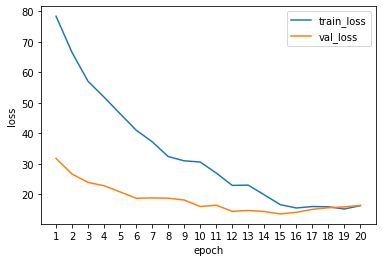

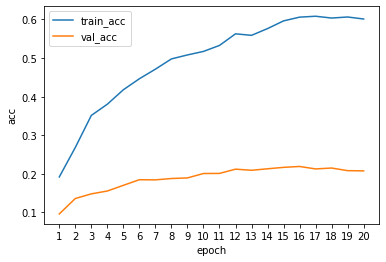

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "single_lstm/without_dropout_1.png" 
filename2 = "single_lstm/without_dropout_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(without_dropout_tl, without_dropout_vl, without_dropout_ta, without_dropout_va, filename1, filename2, 1)

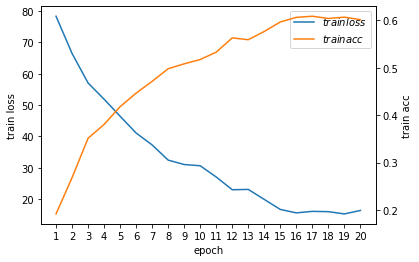

In [ ]:
#訓練の損失と正解率を可視化
filename = "single_lstm/without_dropout_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], without_dropout_tl, without_dropout_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = without_dropout_pred_test
filename = "single_lstm/without_dropout_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       203   25   12   20   37   15   13   9    1
1         4  194    4   39   21   29   11  15    1
2         8   13  232   68   14    7    7  17    3
3         1    0    1  105    4    5    2   1    2
4         7    7    6    3  179    7    4   6    1
5         3   13    1    3   15  163   27  28   12
6         4   12    6   11   10   19  186  11    4
7         1    1    1    5    6   15    4  56    2
8         0    0    0    0    0    2    0   0  227


accuracy : 69.88%


precision : [0.61, 0.61, 0.63, 0.87, 0.81, 0.62, 0.71, 0.62, 0.99]

macro_ave_precision : 0.72


recall : [0.88, 0.73, 0.88, 0.41, 0.63, 0.62, 0.73, 0.39, 0.9]

macro_recall : 0.69


f1 : [0.72, 0.67, 0.73, 0.56, 0.71, 0.62, 0.72, 0.48, 0.94]

macro_f1 : 0.68



In [ ]:
evals_y_without_dropout = []
evals_y_without_dropout.append(without_dropout_ta)
evals_y_without_dropout.append(without_dropout_tl)
evals_y_without_dropout.append(without_dropout_va)
evals_y_without_dropout.append(without_dropout_vl)
evals_y_without_dropout.append(without_dropout_vl)
evals_y_without_dropout.append(without_dropout_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "single_lstm/evals_y_without_dropout.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_without_dropout, f) #保存

## Dropoutありのモデル

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": False, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/single_lstm/"  #保存先のパス
filename = "with_dropout.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
with_dropout_evals_trainval = train_val_evals
with_dropout_evals_test = test_evals
with_dropout_pred_test = y_pred_test

with_dropout_ta = []
with_dropout_tl = []
with_dropout_va = []
with_dropout_vl = []
for key in with_dropout_evals_trainval.keys():
    with_dropout_ta.append(with_dropout_evals_trainval[key]["train_acc"])
    with_dropout_tl.append(with_dropout_evals_trainval[key]["train_loss"])
    with_dropout_va.append(with_dropout_evals_trainval[key]["val_acc"])
    with_dropout_vl.append(with_dropout_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': False, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 79.42, train_acc: 16.45%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 33.02, val_acc: 9.27%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 70.67, train_acc: 23.55%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 28.78, val_acc: 10.61%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 62.23, train_acc: 29.23%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 26.06, val_acc: 12.84%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 56.73, train_acc: 33.77%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 24.87, val_acc: 14.16%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 51.63, train_acc: 37.01%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 22.03, val_acc: 16.12%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 47.59, train_acc: 40.07%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 21.8, val_acc: 16.39%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 43.53, train_acc: 43.31%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 19.41, val_acc: 17.84%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 39.97, train_acc: 44.84%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 19.18, val_acc: 17.63%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 37.11, train_acc: 47.28%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 19.57, val_acc: 17.75%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 34.2, train_acc: 49.59%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 20.42, val_acc: 17.57%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 34.33, train_acc: 48.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 17.25, val_acc: 19.51%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 29.98, train_acc: 52.27%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 16.14, val_acc: 19.71%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 29.08, train_acc: 52.46%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 18.35, val_acc: 18.17%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 31.14, train_acc: 52.13%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 16.56, val_acc: 20.0%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 25.35, train_acc: 55.26%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 15.2, val_acc: 20.73%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 23.64, train_acc: 56.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 14.74, val_acc: 21.28%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 20.3, train_acc: 57.99%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 14.46, val_acc: 21.76%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 22.0, train_acc: 56.57%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 15.07, val_acc: 21.22%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 19.58, train_acc: 58.82%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 13.96, val_acc: 22.09%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 19.14, train_acc: 58.57%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 14.12, val_acc: 22.07%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 19.31, test_acc: 73.9%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       178   14    5   11   13   16    7  16    0
1        13  188   22   15   18   16    6  12    1
2         6    8  201   12    9    2    6   5    0
3         3    8    6  165    3    7    4   8    1
4        17   14   10   12  227    7   10   5    0
5         7   13    3   15    6  183   29  33    1
6         7   11   12   17    6   24  187   9    0
7         0    7    4    6    3    4    3  55    0
8         0    2    0    1    1    3    2   0  250

elapsed_time:214.8[sec]


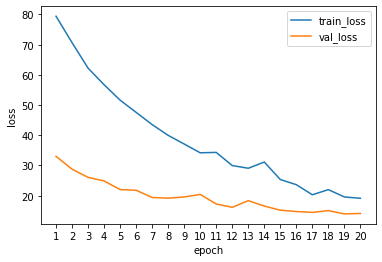

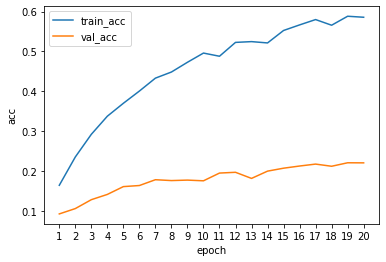

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "single_lstm/with_dropout_1.png" 
filename2 = "single_lstm/with_dropout_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(with_dropout_tl, with_dropout_vl, with_dropout_ta, with_dropout_va, filename1, filename2, 1)

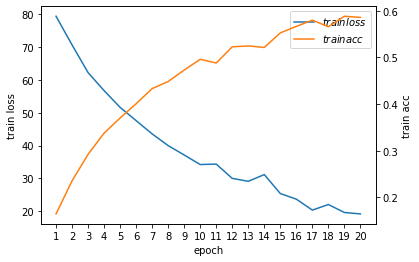

In [ ]:
#訓練の損失と正解率を可視化
filename = "single_lstm/with_dropout_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], with_dropout_tl, with_dropout_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = with_dropout_pred_test
filename = "single_lstm/with_dropout_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       178   14    5   11   13   16    7  16    0
1        13  188   22   15   18   16    6  12    1
2         6    8  201   12    9    2    6   5    0
3         3    8    6  165    3    7    4   8    1
4        17   14   10   12  227    7   10   5    0
5         7   13    3   15    6  183   29  33    1
6         7   11   12   17    6   24  187   9    0
7         0    7    4    6    3    4    3  55    0
8         0    2    0    1    1    3    2   0  250


accuracy : 73.9%


precision : [0.68, 0.65, 0.81, 0.8, 0.75, 0.63, 0.68, 0.67, 0.97]

macro_ave_precision : 0.74


recall : [0.77, 0.71, 0.76, 0.65, 0.79, 0.7, 0.74, 0.38, 0.99]

macro_recall : 0.72


f1 : [0.73, 0.68, 0.79, 0.72, 0.77, 0.66, 0.71, 0.49, 0.98]

macro_f1 : 0.72



In [ ]:
evals_y_with_dropout = []
evals_y_with_dropout.append(with_dropout_ta)
evals_y_with_dropout.append(with_dropout_tl)
evals_y_with_dropout.append(with_dropout_va)
evals_y_with_dropout.append(with_dropout_vl)
evals_y_with_dropout.append(with_dropout_vl)
evals_y_with_dropout.append(with_dropout_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "single_lstm/evals_y_with_dropout.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_with_dropout, f) #保存

## 考察
20epochでのDropoutなしのモデルの訓練誤差は16.36、検証誤差は16.43、汎化誤差は23.76、テストの正解率は69.88%になった。Dropoutありのモデルの訓練誤差は19.14、検証誤差は14.12、汎化誤差は19.31、テストの正解率は73.9%になった。Dropoutありの場合の方が訓練誤差よりも検証誤差、汎化誤差が大きくなることはなくテストの正解率も良くなっていることからDropoutは汎化性能を高めモデルの性能に寄与していることが分かる。Dropoutによりマスクされるノードをランダムに選択し学習の段階ごとに行うことでアンサンブル効果を得ていると考えられる。Dropoutを加えたモデルの方がモデルの性能に良い影響を与えやすいため以降はDropoutを使用したモデルを用いて実験を続ける。

# 複層のLSTM
単層か2層のLSTMを用いたそれぞれのモデルを比較してモデルに与える影響を考察する。

## 二層のLSTMのモデル

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": False ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "multi_lstm_without_dropout.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
multi_lstm_without_dropout_evals_trainval = train_val_evals
multi_lstm_without_dropout_evals_test = test_evals
multi_lstm_without_dropout_pred_test = y_pred_test

multi_lstm_without_dropout_ta = []
multi_lstm_without_dropout_tl = []
multi_lstm_without_dropout_va = []
multi_lstm_without_dropout_vl = []
for key in multi_lstm_without_dropout_evals_trainval.keys():
    multi_lstm_without_dropout_ta.append(multi_lstm_without_dropout_evals_trainval[key]["train_acc"])
    multi_lstm_without_dropout_tl.append(multi_lstm_without_dropout_evals_trainval[key]["train_loss"])
    multi_lstm_without_dropout_va.append(multi_lstm_without_dropout_evals_trainval[key]["val_acc"])
    multi_lstm_without_dropout_vl.append(multi_lstm_without_dropout_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': False, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 78.35, train_acc: 15.07%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 29.91, val_acc: 9.04%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 64.62, train_acc: 24.96%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 27.74, val_acc: 10.94%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 58.52, train_acc: 30.31%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 25.32, val_acc: 12.74%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 57.39, train_acc: 31.03%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 25.89, val_acc: 12.02%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 53.96, train_acc: 34.43%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 23.58, val_acc: 14.66%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 49.69, train_acc: 38.58%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 25.79, val_acc: 13.44%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 48.31, train_acc: 39.22%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 21.75, val_acc: 16.62%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 42.05, train_acc: 43.99%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 20.74, val_acc: 17.18%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 37.31, train_acc: 46.08%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 20.06, val_acc: 17.86%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 34.66, train_acc: 47.77%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 18.72, val_acc: 18.48%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 30.29, train_acc: 50.78%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 17.88, val_acc: 18.87%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 33.16, train_acc: 51.26%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 18.44, val_acc: 19.2%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 27.5, train_acc: 53.01%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 17.22, val_acc: 19.45%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 24.19, train_acc: 54.97%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 17.08, val_acc: 19.61%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 21.92, train_acc: 56.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 18.6, val_acc: 19.03%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 19.42, train_acc: 58.61%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 16.57, val_acc: 20.71%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 17.28, train_acc: 59.54%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 16.29, val_acc: 21.14%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 17.74, train_acc: 59.02%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 15.29, val_acc: 21.35%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 14.88, train_acc: 61.48%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 14.57, val_acc: 21.68%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 12.08, train_acc: 63.23%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 16.08, val_acc: 21.35%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 22.1, test_acc: 71.82%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       156   33   10    7   24    8   11   2    0
1         7  151   10    5    3    9    4   9    0
2         3   14  208    6    4    1    3   3    0
3         2   13    6  188    8   11    6   9    1
4        26   12    8   17  214   13   12   8    0
5         8   14    3    7   15  169   18  31    3
6        21   11   11   10    5   22  188  15    0
7         8   17    7   14   13   29   12  66    1
8         0    0    0    0    0    0    0   0  248

elapsed_time:408.42[sec]


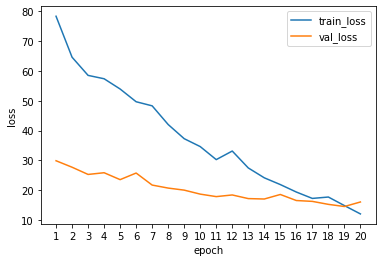

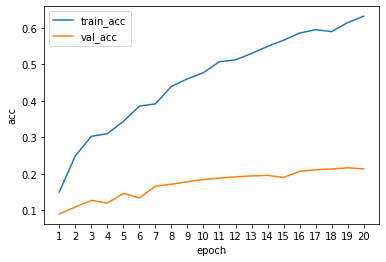

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/multi_lstm_without_dropout_1.png" 
filename2 = "multi_lstm/multi_lstm_without_dropout_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(multi_lstm_without_dropout_tl, multi_lstm_without_dropout_vl, multi_lstm_without_dropout_ta, multi_lstm_without_dropout_va, filename1, filename2, 1)

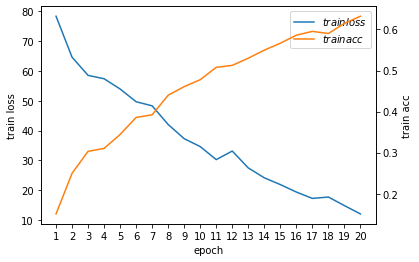

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/multi_lstm_without_dropout_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], multi_lstm_without_dropout_tl, multi_lstm_without_dropout_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = multi_lstm_without_dropout_pred_test
filename = "multi_lstm/multi_lstm_without_dropout_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       156   33   10    7   24    8   11   2    0
1         7  151   10    5    3    9    4   9    0
2         3   14  208    6    4    1    3   3    0
3         2   13    6  188    8   11    6   9    1
4        26   12    8   17  214   13   12   8    0
5         8   14    3    7   15  169   18  31    3
6        21   11   11   10    5   22  188  15    0
7         8   17    7   14   13   29   12  66    1
8         0    0    0    0    0    0    0   0  248


accuracy : 71.82%


precision : [0.62, 0.76, 0.86, 0.77, 0.69, 0.63, 0.66, 0.4, 1.0]

macro_ave_precision : 0.71


recall : [0.68, 0.57, 0.79, 0.74, 0.75, 0.65, 0.74, 0.46, 0.98]

macro_recall : 0.71


f1 : [0.65, 0.65, 0.82, 0.76, 0.72, 0.64, 0.7, 0.43, 0.99]

macro_f1 : 0.71



In [ ]:
evals_y_multi_lstm_without_dropout = []
evals_y_multi_lstm_without_dropout.append(multi_lstm_without_dropout_ta)
evals_y_multi_lstm_without_dropout.append(multi_lstm_without_dropout_tl)
evals_y_multi_lstm_without_dropout.append(multi_lstm_without_dropout_va)
evals_y_multi_lstm_without_dropout.append(multi_lstm_without_dropout_vl)
evals_y_multi_lstm_without_dropout.append(multi_lstm_without_dropout_vl)
evals_y_multi_lstm_without_dropout.append(multi_lstm_without_dropout_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_multi_lstm_without_dropout.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_multi_lstm_without_dropout, f) #保存

## 二層のLSTMモデル + Dropout

In [ ]:
# 20epochでのDropoutなしのモデルの訓練誤差は16.36、検証誤差は16.43、汎化誤差は23.76、テストの正解率は69.88%になった。

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "multi_lstm_with_dropout.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
multi_lstm_with_dropout_evals_trainval = train_val_evals
multi_lstm_with_dropout_evals_test = test_evals
multi_lstm_with_dropout_pred_test = y_pred_test

multi_lstm_with_dropout_ta = []
multi_lstm_with_dropout_tl = []
multi_lstm_with_dropout_va = []
multi_lstm_with_dropout_vl = []
for key in multi_lstm_with_dropout_evals_trainval.keys():
    multi_lstm_with_dropout_ta.append(multi_lstm_with_dropout_evals_trainval[key]["train_acc"])
    multi_lstm_with_dropout_tl.append(multi_lstm_with_dropout_evals_trainval[key]["train_loss"])
    multi_lstm_with_dropout_va.append(multi_lstm_with_dropout_evals_trainval[key]["val_acc"])
    multi_lstm_with_dropout_vl.append(multi_lstm_with_dropout_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 79.11, train_acc: 14.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 31.4, val_acc: 9.72%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 67.74, train_acc: 24.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 27.22, val_acc: 11.64%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 65.08, train_acc: 27.42%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 31.08, val_acc: 12.1%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 61.63, train_acc: 30.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 24.84, val_acc: 13.85%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 55.62, train_acc: 32.89%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 22.79, val_acc: 14.84%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 52.56, train_acc: 34.97%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 21.82, val_acc: 15.55%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 46.3, train_acc: 39.76%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 20.66, val_acc: 16.58%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 44.14, train_acc: 41.52%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 21.13, val_acc: 16.23%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 40.07, train_acc: 44.03%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 18.3, val_acc: 18.58%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 37.61, train_acc: 46.31%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 18.04, val_acc: 19.03%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 34.62, train_acc: 48.99%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 16.33, val_acc: 19.86%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 31.55, train_acc: 51.57%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 18.49, val_acc: 19.1%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 28.78, train_acc: 52.85%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 15.82, val_acc: 20.25%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 26.03, train_acc: 54.77%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 14.88, val_acc: 21.39%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 23.81, train_acc: 56.54%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 16.97, val_acc: 20.93%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 21.5, train_acc: 57.72%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 14.18, val_acc: 21.74%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 17.97, train_acc: 59.41%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 14.24, val_acc: 21.94%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 15.49, train_acc: 60.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 13.56, val_acc: 22.5%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 13.86, train_acc: 61.91%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 14.49, val_acc: 22.3%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 14.1, train_acc: 61.79%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 14.62, val_acc: 22.28%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 19.95, test_acc: 76.12%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       185    6    5    9    5   13    3   3    0
1         3  179    6    1    4   14    3   7    0
2         5    4  222    8    1    7    1   5    0
3         1    3    7  179    0    8    3   6    1
4        23   20    9   22  262   23   21  23    1
5         5   35    5    9    4  153   17  29    0
6         5    7    5   10    9   23  195  11    0
7         2   11    4   16    1   21   11  57    0
8         2    0    0    0    0    0    0   2  251

elapsed_time:407.99[sec]


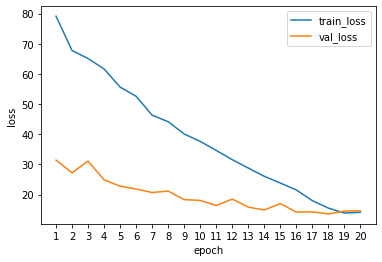

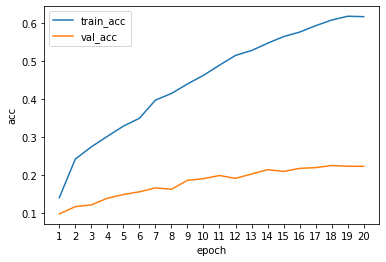

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/multi_lstm_with_dropout_1.png" 
filename2 = "multi_lstm/multi_lstm_with_dropout_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(multi_lstm_with_dropout_tl, multi_lstm_with_dropout_vl, multi_lstm_with_dropout_ta, multi_lstm_with_dropout_va, filename1, filename2, 1)

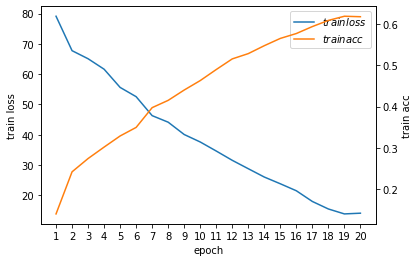

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/multi_lstm_with_dropout_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], multi_lstm_with_dropout_tl, multi_lstm_with_dropout_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = multi_lstm_with_dropout_pred_test
filename = "multi_lstm/multi_lstm_with_dropout_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       185    6    5    9    5   13    3   3    0
1         3  179    6    1    4   14    3   7    0
2         5    4  222    8    1    7    1   5    0
3         1    3    7  179    0    8    3   6    1
4        23   20    9   22  262   23   21  23    1
5         5   35    5    9    4  153   17  29    0
6         5    7    5   10    9   23  195  11    0
7         2   11    4   16    1   21   11  57    0
8         2    0    0    0    0    0    0   2  251


accuracy : 76.12%


precision : [0.81, 0.82, 0.88, 0.86, 0.65, 0.6, 0.74, 0.46, 0.98]

macro_ave_precision : 0.76


recall : [0.8, 0.68, 0.84, 0.7, 0.92, 0.58, 0.77, 0.4, 0.99]

macro_recall : 0.74


f1 : [0.8, 0.74, 0.86, 0.77, 0.76, 0.59, 0.75, 0.43, 0.99]

macro_f1 : 0.74



In [ ]:
evals_y_multi_lstm_with_dropout = []
evals_y_multi_lstm_with_dropout.append(multi_lstm_with_dropout_ta)
evals_y_multi_lstm_with_dropout.append(multi_lstm_with_dropout_tl)
evals_y_multi_lstm_with_dropout.append(multi_lstm_with_dropout_va)
evals_y_multi_lstm_with_dropout.append(multi_lstm_with_dropout_vl)
evals_y_multi_lstm_with_dropout.append(multi_lstm_with_dropout_vl)
evals_y_multi_lstm_with_dropout.append(multi_lstm_with_dropout_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_multi_lstm_with_dropout.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_multi_lstm_with_dropout, f) #保存

## 考察
20epochでの二層のLSTMを用いたモデルの訓練誤差は12.08、検証誤差は16.08、汎化誤差は22.1、正解率は71.82%であった。更にDropoutを加えた場合では、訓練誤差は14.1、検証誤差は14.62、汎化誤差は19.95、正解率は76.12%であった。(Dropoutなしの単層LSTMのモデルの訓練誤差は16.36、検証誤差は16.43、汎化誤差は23.76、テストの正解率は69.88%)
二層のLSTMのモデルの方が単層のLSTMの場合と比べて、訓練誤差が小さくなり検証誤差、汎化誤差を下回っていることから過学習していると分かる。二層にしたことで特徴量が増えたことでモデルが複雑になり過学習になったと考えられる。Dropoutを加えると、訓練誤差と検証誤差、汎化誤差との差分が狭まり過学習を抑制する効果があり、テストの正解率も向上した。二層のLSTMにDropoutを加えればモデルとして機能する可能性があると思われる。以降は実験的に二層のLSTMを用いて実験を続ける。

# その他のハイパラメータでの検証
比較する基準となるハイパパラメータの設定を2層のLSTM、ドロップアウトあり、ドロップアウトの割合を0.5、バッチサイズを100、学習率を0.001、埋め込み層の次元を20、隠れ層の次元を100とする。  
二層のLSTMモデル+Dropoutの実験結果より20epochの訓練誤差:14.1、検証誤差:14.62、汎化誤差:19.95、テストの正解率:76.12%をそれぞれの以下実験での比較対象とする。

## Batch_Size 50

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 50, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "bs_50.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
bs_50_evals_trainval = train_val_evals
bs_50_evals_test = test_evals
bs_50_pred_test = y_pred_test

bs_50_ta = []
bs_50_tl = []
bs_50_va = []
bs_50_vl = []
for key in bs_50_evals_trainval.keys():
    bs_50_ta.append(bs_50_evals_trainval[key]["train_acc"])
    bs_50_tl.append(bs_50_evals_trainval[key]["train_loss"])
    bs_50_va.append(bs_50_evals_trainval[key]["val_acc"])
    bs_50_vl.append(bs_50_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 50, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 152.58, train_acc: 15.17%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1, val_loss: 57.72, val_acc: 9.87%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 130.15, train_acc: 23.58%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2, val_loss: 53.48, val_acc: 10.98%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 120.13, train_acc: 27.58%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3, val_loss: 49.41, val_acc: 12.61%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 110.71, train_acc: 31.67%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4, val_loss: 45.91, val_acc: 14.51%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 101.12, train_acc: 36.07%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5, val_loss: 44.86, val_acc: 14.91%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 90.29, train_acc: 40.01%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6, val_loss: 39.75, val_acc: 17.22%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 81.05, train_acc: 42.79%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7, val_loss: 45.16, val_acc: 15.46%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 84.1, train_acc: 42.38%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8, val_loss: 36.57, val_acc: 17.65%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 70.01, train_acc: 47.34%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9, val_loss: 35.64, val_acc: 18.62%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 60.83, train_acc: 50.85%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10, val_loss: 33.28, val_acc: 19.63%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 52.47, train_acc: 53.74%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11, val_loss: 33.23, val_acc: 20.21%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 49.84, train_acc: 54.09%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12, val_loss: 30.22, val_acc: 20.91%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 43.58, train_acc: 56.34%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13, val_loss: 29.05, val_acc: 21.61%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 35.84, train_acc: 59.6%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14, val_loss: 28.36, val_acc: 21.92%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 32.46, train_acc: 60.63%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15, val_loss: 27.96, val_acc: 22.36%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 28.7, train_acc: 61.56%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16, val_loss: 29.64, val_acc: 21.92%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 28.79, train_acc: 62.01%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17, val_loss: 29.44, val_acc: 21.94%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 28.41, train_acc: 61.7%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18, val_loss: 29.6, val_acc: 22.17%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 23.62, train_acc: 63.79%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19, val_loss: 28.18, val_acc: 22.81%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 19.85, train_acc: 64.49%


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20, val_loss: 27.81, val_acc: 22.81%


-------------------------テスト-------------------------


  0%|          | 0/45 [00:00<?, ?it/s]

test_loss: 36.73, test_acc: 76.93%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       167    9    2    5   15    5    4   1    0
1        11  196    0    1    6   14    4   4    0
2        15    3  244   27    4    2    5   5    0
3         7    5   12  193    3    9    6  16    3
4        18   19    2    4  215   23   10  12    0
5         2   17    1    2    9  171   11  25    2
6         9   11    1    8   21   13  200  12    0
7         2    4    1   11   13   23   14  67    0
8         0    1    0    3    0    2    0   1  248

elapsed_time:650.71[sec]


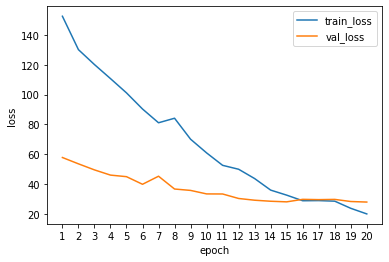

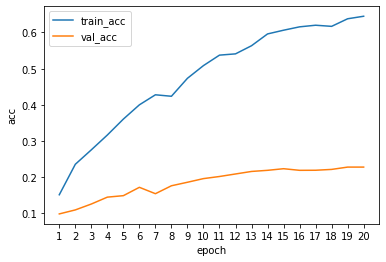

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/bs_50_1.png" 
filename2 = "multi_lstm/bs_50_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(bs_50_tl, bs_50_vl, bs_50_ta, bs_50_va, filename1, filename2, 1)

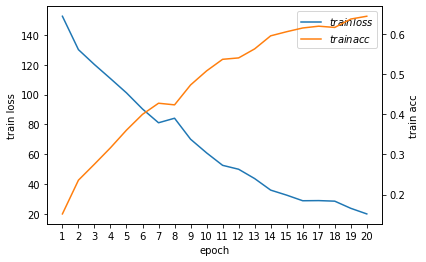

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/bs_50_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], bs_50_tl, bs_50_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = bs_50_pred_test
filename = "multi_lstm/bs_50_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       167    9    2    5   15    5    4   1    0
1        11  196    0    1    6   14    4   4    0
2        15    3  244   27    4    2    5   5    0
3         7    5   12  193    3    9    6  16    3
4        18   19    2    4  215   23   10  12    0
5         2   17    1    2    9  171   11  25    2
6         9   11    1    8   21   13  200  12    0
7         2    4    1   11   13   23   14  67    0
8         0    1    0    3    0    2    0   1  248


accuracy : 76.93%


precision : [0.8, 0.83, 0.8, 0.76, 0.71, 0.71, 0.73, 0.5, 0.97]

macro_ave_precision : 0.76


recall : [0.72, 0.74, 0.93, 0.76, 0.75, 0.65, 0.79, 0.47, 0.98]

macro_recall : 0.75


f1 : [0.76, 0.78, 0.86, 0.76, 0.73, 0.68, 0.76, 0.48, 0.98]

macro_f1 : 0.75



In [ ]:
evals_y_bs_50 = []
evals_y_bs_50.append(bs_50_ta)
evals_y_bs_50.append(bs_50_tl)
evals_y_bs_50.append(bs_50_va)
evals_y_bs_50.append(bs_50_vl)
evals_y_bs_50.append(bs_50_vl)
evals_y_bs_50.append(bs_50_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_bs_50.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_bs_50, f) #保存

## Batch_Size 200

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 200, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "bs_200.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
bs_200_evals_trainval = train_val_evals
bs_200_evals_test = test_evals
bs_200_pred_test = y_pred_test

bs_200_ta = []
bs_200_tl = []
bs_200_va = []
bs_200_vl = []
for key in bs_200_evals_trainval.keys():
    bs_200_ta.append(bs_200_evals_trainval[key]["train_acc"])
    bs_200_tl.append(bs_200_evals_trainval[key]["train_loss"])
    bs_200_va.append(bs_200_evals_trainval[key]["val_acc"])
    bs_200_vl.append(bs_200_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 200, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 41.43, train_acc: 12.57%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1, val_loss: 16.96, val_acc: 7.62%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 37.9, train_acc: 18.25%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2, val_loss: 15.14, val_acc: 9.46%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 34.76, train_acc: 23.84%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3, val_loss: 14.29, val_acc: 10.51%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 33.11, train_acc: 25.02%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4, val_loss: 13.67, val_acc: 12.14%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 30.68, train_acc: 29.34%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5, val_loss: 12.78, val_acc: 12.74%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 28.5, train_acc: 32.12%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6, val_loss: 12.05, val_acc: 13.62%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 27.02, train_acc: 34.5%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7, val_loss: 11.33, val_acc: 15.09%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 25.6, train_acc: 36.81%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8, val_loss: 11.09, val_acc: 15.67%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 23.94, train_acc: 38.44%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9, val_loss: 10.79, val_acc: 15.57%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 22.32, train_acc: 41.04%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10, val_loss: 10.62, val_acc: 16.33%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 22.2, train_acc: 42.82%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11, val_loss: 10.52, val_acc: 16.62%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 23.13, train_acc: 42.82%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12, val_loss: 16.18, val_acc: 10.55%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 25.9, train_acc: 40.11%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13, val_loss: 9.95, val_acc: 17.73%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 20.38, train_acc: 47.42%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14, val_loss: 9.29, val_acc: 18.46%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 18.21, train_acc: 49.52%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15, val_loss: 9.04, val_acc: 18.52%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 16.14, train_acc: 51.38%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16, val_loss: 8.78, val_acc: 19.03%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 14.67, train_acc: 52.99%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17, val_loss: 9.01, val_acc: 18.7%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 14.05, train_acc: 52.68%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18, val_loss: 8.41, val_acc: 19.71%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 12.99, train_acc: 55.51%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19, val_loss: 8.18, val_acc: 20.25%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 12.91, train_acc: 56.19%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20, val_loss: 8.18, val_acc: 20.0%


-------------------------テスト-------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

test_loss: 12.06, test_acc: 69.43%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       174   17    5    1   23   12    6   5    0
1        12  142    6   10   15   14    8   6    1
2        11    6  225   14    6    4    2   0    0
3         7   35   16  175   15   24    6  13    3
4        14   15    7   11  188   14    7  12    1
5         6   32    2   18   16  139   24  25    3
6         2   13    1   17   13   35  190  19    3
7         5    4    1    8    9   16    9  61    1
8         0    1    0    0    1    4    2   2  241

elapsed_time:275.6[sec]


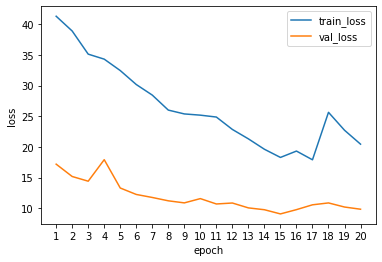

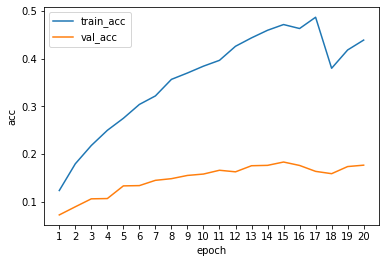

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/bs_200_1.png" 
filename2 = "multi_lstm/bs_200_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(bs_200_tl, bs_200_vl, bs_200_ta, bs_200_va, filename1, filename2, 1)

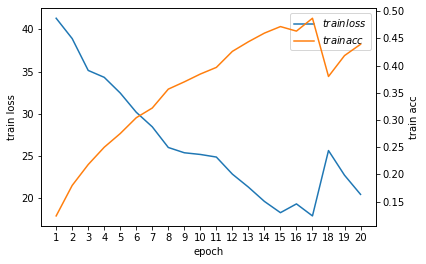

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/bs_200_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], bs_200_tl, bs_200_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = bs_200_pred_test
filename = "multi_lstm/bs_200_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test   0   1    2    3    4    5    6   7    8
y_pred                                          
0       79  79   12    7   56   24   12  12    0
1       36  73    7    4    7   16    8   8    0
2       27  19  205   33   16   14    6   8    0
3        1   8   16  164    2   31    1  21    1
4       44  29    5    5  177   10    9   7    0
5       17  41    8   12    7  120   26  34    0
6       24  13    9   21   16   29  187  12    1
7        3   3    1    6    4   16    4  41    0
8        0   0    0    2    1    2    1   0  251


accuracy : 58.66%


precision : [0.28, 0.46, 0.62, 0.67, 0.62, 0.45, 0.6, 0.53, 0.98]

macro_ave_precision : 0.58


recall : [0.34, 0.28, 0.78, 0.65, 0.62, 0.46, 0.74, 0.29, 0.99]

macro_recall : 0.57


f1 : [0.31, 0.34, 0.69, 0.66, 0.62, 0.46, 0.66, 0.37, 0.98]

macro_f1 : 0.57



In [ ]:
evals_y_bs_200 = []
evals_y_bs_200.append(bs_200_ta)
evals_y_bs_200.append(bs_200_tl)
evals_y_bs_200.append(bs_200_va)
evals_y_bs_200.append(bs_200_vl)
evals_y_bs_200.append(bs_200_vl)
evals_y_bs_200.append(bs_200_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_bs_200.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_bs_200, f) #保存

## 考察
20epochでのバッチサイズ50のモデルの訓練誤差は19.85、検証誤差は27.81、汎化誤差は36.73、テストの正解率は76.93％、バッチサイズ200のモデルの訓練誤差は12.91、検証誤差は8.18、汎化誤差は12.06、テストの正解率は69.43％になった。（バッチサイズ100のモデルの訓練誤差は14.1、検証誤差は14.62、汎化誤差は19.95、正解率は76.12%）  
バッチサイズ50の結果よりバッチサイズを小さくすると汎化誤差は訓練誤差を大きく上回り過学習となりやすい。バッチサイズ100では若干過学習気味ではあるが訓練誤差と検証誤差はほぼ同じ値で汎化誤差は訓練誤差よりも5ほど高い程度でバッチサイズ50と比べて汎化性能は改善されている。テストの正解率は76.12%とバッチサイズ50の時と比べてもほとんど変わらない。さらにバッチサイズ200にすると正解率は69.43%と10％ほど落ちるが検証誤差、汎化誤差は訓練誤差を完全に下回りは汎化性能は向上する。バッチサイズを小さくするとエポックごとの学習でのパラメータを更新する回数が増えるので訓練データに適合されすぎると考えられる。  
後のハイパパラメータの再調整で汎化誤差、テストの正解率を見てバッチサイズを100以上で調整する。

## Emdedding dim 50

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 50, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "ed_50.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
ed_50_evals_trainval = train_val_evals
ed_50_evals_test = test_evals
ed_50_pred_test = y_pred_test

ed_50_ta = []
ed_50_tl = []
ed_50_va = []
ed_50_vl = []
for key in ed_50_evals_trainval.keys():
    ed_50_ta.append(ed_50_evals_trainval[key]["train_acc"])
    ed_50_tl.append(ed_50_evals_trainval[key]["train_loss"])
    ed_50_va.append(ed_50_evals_trainval[key]["val_acc"])
    ed_50_vl.append(ed_50_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 50, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 76.83, train_acc: 19.16%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 29.63, val_acc: 9.39%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 65.11, train_acc: 26.61%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 26.98, val_acc: 12.12%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 57.85, train_acc: 32.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 22.68, val_acc: 15.54%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 48.34, train_acc: 39.39%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 20.67, val_acc: 16.99%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 42.66, train_acc: 43.1%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 18.36, val_acc: 18.54%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 38.11, train_acc: 47.58%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 18.2, val_acc: 19.01%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 33.28, train_acc: 49.92%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 16.0, val_acc: 20.15%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 25.98, train_acc: 54.36%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 15.93, val_acc: 20.54%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 23.35, train_acc: 56.42%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 13.93, val_acc: 21.92%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 18.81, train_acc: 59.21%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 13.8, val_acc: 22.13%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 16.81, train_acc: 60.47%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 15.21, val_acc: 21.64%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 15.2, train_acc: 61.66%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 13.92, val_acc: 22.3%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 12.99, train_acc: 63.21%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 14.06, val_acc: 22.42%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 10.63, train_acc: 64.57%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 14.67, val_acc: 22.52%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 9.06, train_acc: 65.19%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 14.54, val_acc: 22.61%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 7.88, train_acc: 65.81%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 15.25, val_acc: 22.65%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 6.77, train_acc: 66.49%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 14.81, val_acc: 22.63%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 5.09, train_acc: 67.51%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 15.17, val_acc: 22.98%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 5.57, train_acc: 67.38%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 16.72, val_acc: 22.6%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 12.38, train_acc: 63.69%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 16.03, val_acc: 21.47%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 21.41, test_acc: 73.13%

多クラスの混同行列
y_test   0    1    2    3    4    5    6   7    8
y_pred                                           
0       97    3    3    5   15    2    1   0    0
1       16  200    5    7   20   22    1  14    1
2       26    4  203    3    3    1    1   4    0
3       36   10   40  207    8   14    9  15    0
4       19   12    4    5  211   10   13   7    0
5        9   17    0    4    4  168   17  16    0
6       13    4    3    7   21   23  201   7    0
7       15   14    5   16    4   20   10  78    0
8        0    1    0    0    0    2    1   2  252

elapsed_time:418.75[sec]


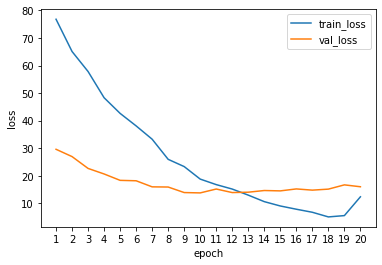

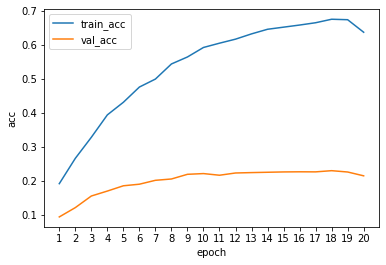

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/ed_50_1.png" 
filename2 = "multi_lstm/ed_50_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(ed_50_tl, ed_50_vl, ed_50_ta, ed_50_va, filename1, filename2, 1)

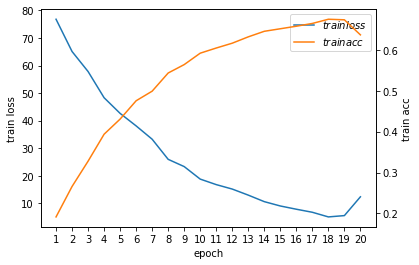

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/ed_50_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], ed_50_tl, ed_50_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = ed_50_pred_test
filename = "multi_lstm/ed_50_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test   0    1    2    3    4    5    6   7    8
y_pred                                           
0       97    3    3    5   15    2    1   0    0
1       16  200    5    7   20   22    1  14    1
2       26    4  203    3    3    1    1   4    0
3       36   10   40  207    8   14    9  15    0
4       19   12    4    5  211   10   13   7    0
5        9   17    0    4    4  168   17  16    0
6       13    4    3    7   21   23  201   7    0
7       15   14    5   16    4   20   10  78    0
8        0    1    0    0    0    2    1   2  252


accuracy : 73.13%


precision : [0.77, 0.7, 0.83, 0.61, 0.75, 0.71, 0.72, 0.48, 0.98]

macro_ave_precision : 0.73


recall : [0.42, 0.75, 0.77, 0.81, 0.74, 0.64, 0.79, 0.55, 1.0]

macro_recall : 0.72


f1 : [0.54, 0.73, 0.8, 0.7, 0.74, 0.68, 0.75, 0.51, 0.99]

macro_f1 : 0.72



In [ ]:
evals_y_ed_50 = []
evals_y_ed_50.append(ed_50_ta)
evals_y_ed_50.append(ed_50_tl)
evals_y_ed_50.append(ed_50_va)
evals_y_ed_50.append(ed_50_vl)
evals_y_ed_50.append(ed_50_vl)
evals_y_ed_50.append(ed_50_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_ed_50.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_ed_50, f) #保存

##Embedding dim 100

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 100, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "ed_100.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
ed_100_evals_trainval = train_val_evals
ed_100_evals_test = test_evals
ed_100_pred_test = y_pred_test

ed_100_ta = []
ed_100_tl = []
ed_100_va = []
ed_100_vl = []
for key in ed_100_evals_trainval.keys():
    ed_100_ta.append(ed_100_evals_trainval[key]["train_acc"])
    ed_100_tl.append(ed_100_evals_trainval[key]["train_loss"])
    ed_100_va.append(ed_100_evals_trainval[key]["val_acc"])
    ed_100_vl.append(ed_100_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 100, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 76.74, train_acc: 19.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 27.81, val_acc: 12.22%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 59.25, train_acc: 31.44%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 22.99, val_acc: 15.5%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 47.07, train_acc: 39.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 20.07, val_acc: 17.49%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 38.14, train_acc: 46.94%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 16.92, val_acc: 19.43%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 29.56, train_acc: 52.72%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 14.41, val_acc: 21.66%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 22.01, train_acc: 57.27%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 12.88, val_acc: 22.46%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 20.54, train_acc: 59.52%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 11.9, val_acc: 23.06%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 19.26, train_acc: 59.41%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 13.73, val_acc: 22.03%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 16.44, train_acc: 60.69%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 12.1, val_acc: 23.18%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 12.11, train_acc: 63.17%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 11.67, val_acc: 23.53%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 9.34, train_acc: 64.62%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 11.89, val_acc: 23.86%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 7.41, train_acc: 66.39%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 12.24, val_acc: 23.68%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 6.19, train_acc: 66.82%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 12.41, val_acc: 23.72%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 5.16, train_acc: 67.26%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 12.6, val_acc: 23.49%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 5.17, train_acc: 67.61%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 14.23, val_acc: 23.62%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 4.43, train_acc: 67.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 13.52, val_acc: 23.72%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 2.8, train_acc: 68.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 14.27, val_acc: 23.51%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 2.8, train_acc: 68.68%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 14.73, val_acc: 23.91%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 2.05, train_acc: 69.26%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 15.03, val_acc: 23.82%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 1.92, train_acc: 69.26%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 14.85, val_acc: 23.93%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 19.92, test_acc: 80.51%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       205   10    6    3   24    3    4   0    0
1         3  212    6    3   10   14    6  10    0
2         4   15  236   24    3    5    5   5    0
3         0    3    4  187    7    9    7   6    0
4        12    7    3   12  222    7    7  11    0
5         1    7    0   11    5  177   14  15    1
6         5    4    5    4    7   20  199   6    0
7         1    7    3   10    8   27   12  90    0
8         0    0    0    0    0    0    0   0  252

elapsed_time:417.12[sec]


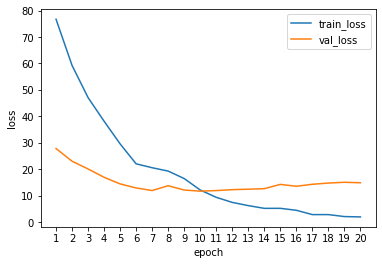

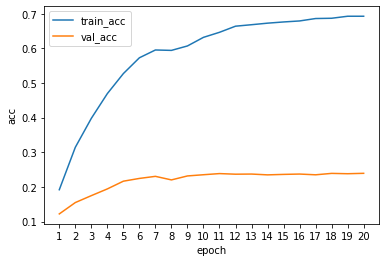

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/ed_100_1.png" 
filename2 = "multi_lstm/ed_100_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(ed_100_tl, ed_100_vl, ed_100_ta, ed_100_va, filename1, filename2, 1)

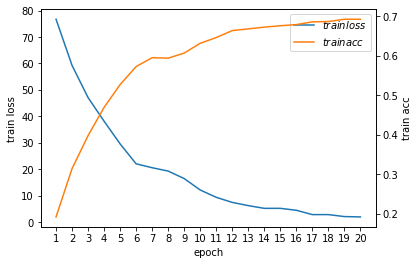

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/ed_100_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], ed_100_tl, ed_100_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = ed_100_pred_test
filename = "multi_lstm/ed_100_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       205   10    6    3   24    3    4   0    0
1         3  212    6    3   10   14    6  10    0
2         4   15  236   24    3    5    5   5    0
3         0    3    4  187    7    9    7   6    0
4        12    7    3   12  222    7    7  11    0
5         1    7    0   11    5  177   14  15    1
6         5    4    5    4    7   20  199   6    0
7         1    7    3   10    8   27   12  90    0
8         0    0    0    0    0    0    0   0  252


accuracy : 80.51%


precision : [0.8, 0.8, 0.79, 0.84, 0.79, 0.77, 0.8, 0.57, 1.0]

macro_ave_precision : 0.8


recall : [0.89, 0.8, 0.9, 0.74, 0.78, 0.68, 0.78, 0.63, 1.0]

macro_recall : 0.8


f1 : [0.84, 0.8, 0.84, 0.78, 0.78, 0.72, 0.79, 0.6, 1.0]

macro_f1 : 0.8



In [ ]:
evals_y_ed_100 = []
evals_y_ed_100.append(ed_100_ta)
evals_y_ed_100.append(ed_100_tl)
evals_y_ed_100.append(ed_100_va)
evals_y_ed_100.append(ed_100_vl)
evals_y_ed_100.append(ed_100_vl)
evals_y_ed_100.append(ed_100_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_ed_100.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_ed_100, f) #保存

## 考察
20epochの埋め込み層の次元50のモデルの訓練誤差は12.38、検証誤差は16.03、汎化誤差は21.41、テストの正解率は73.13％、埋め込み層の次元100のモデルの訓練誤差は1.92、検証誤差は14.85、汎化誤差は19.92、テストの正解率は80.51％になった。（埋め込み層の次元20のモデルの訓練誤差は14.1、検証誤差は14.62、汎化誤差は19.95、正解率は76.12%）  
埋め込み層20次元の結果より検証誤差と汎化誤差が訓練誤差を下回っていることから埋め込み層の次元を小さくすると過学習を抑制していると分かる。一方で埋め込み次元を大きくすると検証誤差と汎化誤差が訓練誤差を上回り過学習になっている。単語のデータを大きな次元の埋め込み層に入力することで単語を表現する特徴量が増えるので学習する際に訓練データに適合され過ぎるためだと考えられる。テストの正解率はどのパターンでも70%以上を保ち、平均5%前後の変化ほどである。今回の実験では埋め込み次元を最大でも100次元ほどしか設定していなく埋め込み層はモデルの層の入力部でモデル全体からすると部分的にしか直接的に作用していないため次元を調整しても正解率に大きく影響しないと考えられる。  
後のハイパパラメータの再調整で汎化誤差やテストの正解率を見て埋め込み層の次元は50以下で調整する。

##Hidden dim 50

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 50, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "hd_50.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
hd_50_evals_trainval = train_val_evals
hd_50_evals_test = test_evals
hd_50_pred_test = y_pred_test

hd_50_ta = []
hd_50_tl = []
hd_50_va = []
hd_50_vl = []
for key in hd_50_evals_trainval.keys():
    hd_50_ta.append(hd_50_evals_trainval[key]["train_acc"])
    hd_50_tl.append(hd_50_evals_trainval[key]["train_loss"])
    hd_50_va.append(hd_50_evals_trainval[key]["val_acc"])
    hd_50_vl.append(hd_50_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 50, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 80.58, train_acc: 11.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 34.41, val_acc: 7.53%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 75.34, train_acc: 19.38%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 30.26, val_acc: 10.59%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 66.78, train_acc: 24.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 26.8, val_acc: 11.87%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 61.34, train_acc: 28.32%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 26.19, val_acc: 12.59%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 57.4, train_acc: 30.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 23.83, val_acc: 13.6%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 60.29, train_acc: 32.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 26.06, val_acc: 12.34%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 53.46, train_acc: 35.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 22.75, val_acc: 15.77%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 49.35, train_acc: 38.05%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 21.23, val_acc: 16.39%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 54.43, train_acc: 34.29%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 22.81, val_acc: 14.99%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 48.76, train_acc: 38.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 21.64, val_acc: 16.41%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 44.06, train_acc: 40.87%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 20.02, val_acc: 16.72%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 42.61, train_acc: 42.22%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 20.44, val_acc: 16.72%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 39.8, train_acc: 44.24%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 20.8, val_acc: 17.34%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 43.5, train_acc: 41.7%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 19.39, val_acc: 17.57%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 37.89, train_acc: 46.22%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 18.24, val_acc: 18.44%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 35.0, train_acc: 48.18%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 18.11, val_acc: 18.7%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 32.72, train_acc: 48.99%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 17.2, val_acc: 19.28%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 31.21, train_acc: 50.16%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 17.03, val_acc: 19.34%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 29.66, train_acc: 51.38%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 16.8, val_acc: 19.57%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 27.45, train_acc: 52.13%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 16.61, val_acc: 19.69%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 23.08, test_acc: 66.62%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       115   25    9   10   56    9   10   9    0
1        11  159   37   27   10   16    4  10    6
2         3   30  192   12    6    2    3   3    1
3         3   18    4  161    0   13    6  12    0
4        66    8    6    4  187   11    8   4    1
5         8   13    3   19    7  170   24  31    5
6        20    4    9   13   14   20  193  12    1
7         3    7    3    6    5   18    6  59    2
8         2    1    0    2    1    3    0   3  237

elapsed_time:334.1[sec]


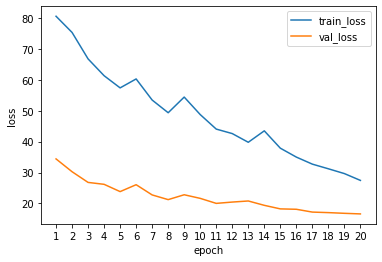

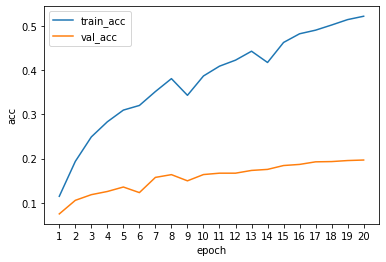

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/hd_50_1.png" 
filename2 = "multi_lstm/hd_50_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(hd_50_tl, hd_50_vl, hd_50_ta, hd_50_va, filename1, filename2, 1)

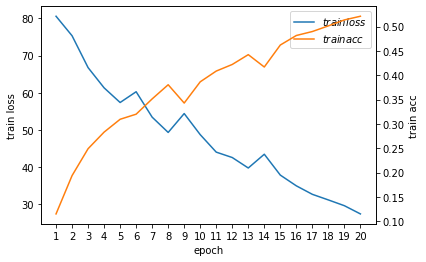

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/hd_50_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], hd_50_tl, hd_50_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = hd_50_pred_test
filename = "multi_lstm/hd_50_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       115   25    9   10   56    9   10   9    0
1        11  159   37   27   10   16    4  10    6
2         3   30  192   12    6    2    3   3    1
3         3   18    4  161    0   13    6  12    0
4        66    8    6    4  187   11    8   4    1
5         8   13    3   19    7  170   24  31    5
6        20    4    9   13   14   20  193  12    1
7         3    7    3    6    5   18    6  59    2
8         2    1    0    2    1    3    0   3  237


accuracy : 66.62%


precision : [0.47, 0.57, 0.76, 0.74, 0.63, 0.61, 0.67, 0.54, 0.95]

macro_ave_precision : 0.66


recall : [0.5, 0.6, 0.73, 0.63, 0.65, 0.65, 0.76, 0.41, 0.94]

macro_recall : 0.65


f1 : [0.49, 0.58, 0.75, 0.68, 0.64, 0.63, 0.71, 0.47, 0.94]

macro_f1 : 0.66



In [ ]:
evals_y_hd_50 = []
evals_y_hd_50.append(hd_50_ta)
evals_y_hd_50.append(hd_50_tl)
evals_y_hd_50.append(hd_50_va)
evals_y_hd_50.append(hd_50_vl)
evals_y_hd_50.append(hd_50_vl)
evals_y_hd_50.append(hd_50_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_hd_50.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_hd_50, f) #保存

In [ ]:
##モデルの概要## (dropout)は任意
"""
input_data => (dropout) => emdedding_layer => (dropout) => lstm_layer
=> (dropout) => lstm_layer => (dropout) => linear_layer => softmax_layer => outpot
"""

##Hidden dim 150

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 150, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "hd_150.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
hd_150_evals_trainval = train_val_evals
hd_150_evals_test = test_evals
hd_150_pred_test = y_pred_test

hd_150_ta = []
hd_150_tl = []
hd_150_va = []
hd_150_vl = []
for key in hd_150_evals_trainval.keys():
    hd_150_ta.append(hd_150_evals_trainval[key]["train_acc"])
    hd_150_tl.append(hd_150_evals_trainval[key]["train_loss"])
    hd_150_va.append(hd_150_evals_trainval[key]["val_acc"])
    hd_150_vl.append(hd_150_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 150, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 76.92, train_acc: 15.38%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 35.9, val_acc: 8.17%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 69.33, train_acc: 22.63%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 27.76, val_acc: 11.29%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 63.75, train_acc: 26.73%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 26.19, val_acc: 12.61%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 58.15, train_acc: 31.03%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 23.9, val_acc: 15.21%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 52.76, train_acc: 35.63%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 24.41, val_acc: 14.33%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 48.82, train_acc: 38.77%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 21.25, val_acc: 16.21%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 42.59, train_acc: 42.11%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 20.58, val_acc: 16.68%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 46.43, train_acc: 40.92%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 19.42, val_acc: 17.57%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 38.28, train_acc: 45.97%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 17.89, val_acc: 18.74%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 34.8, train_acc: 48.16%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 17.52, val_acc: 19.03%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 31.1, train_acc: 50.87%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 16.35, val_acc: 19.8%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 29.14, train_acc: 52.99%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 15.81, val_acc: 20.19%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 27.02, train_acc: 54.25%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 15.22, val_acc: 20.93%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 24.38, train_acc: 55.64%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 14.51, val_acc: 21.37%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 22.1, train_acc: 57.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 16.25, val_acc: 20.64%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 22.13, train_acc: 56.92%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 13.65, val_acc: 22.03%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 21.42, train_acc: 57.87%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 13.93, val_acc: 22.15%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 19.33, train_acc: 59.08%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 14.6, val_acc: 21.82%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 17.85, train_acc: 59.58%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 13.67, val_acc: 22.5%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 14.84, train_acc: 61.37%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 13.09, val_acc: 22.69%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 18.99, test_acc: 77.39%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       195    8    6    2    5    5    1   4    0
1         4  193   16    5   14   10    3  10    0
2         2   13  219    8    0    4    4   2    0
3         2    6    2  172    7    5    3   8    0
4        13   10    8   21  227    8   18   9    0
5         5   19    6   16    3  188   21  41    0
6         6    6    5   13   15   20  200   5    0
7         4   10    1   15   15   22    4  64    0
8         0    0    0    2    0    0    0   0  253

elapsed_time:637.31[sec]


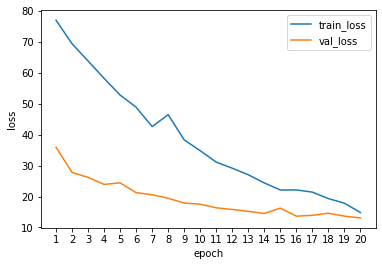

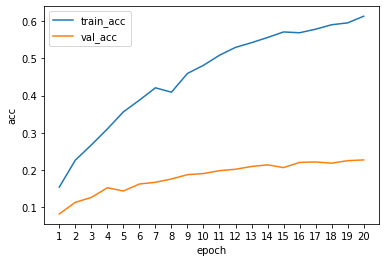

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/hd_150_1.png" 
filename2 = "multi_lstm/hd_150_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(hd_150_tl, hd_150_vl, hd_150_ta, hd_150_va, filename1, filename2, 1)

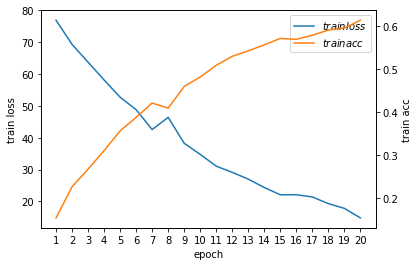

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/hd_150_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], hd_150_tl, hd_150_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = hd_150_pred_test
filename = "multi_lstm/hd_150_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       195    8    6    2    5    5    1   4    0
1         4  193   16    5   14   10    3  10    0
2         2   13  219    8    0    4    4   2    0
3         2    6    2  172    7    5    3   8    0
4        13   10    8   21  227    8   18   9    0
5         5   19    6   16    3  188   21  41    0
6         6    6    5   13   15   20  200   5    0
7         4   10    1   15   15   22    4  64    0
8         0    0    0    2    0    0    0   0  253


accuracy : 77.39%


precision : [0.86, 0.76, 0.87, 0.84, 0.72, 0.63, 0.74, 0.47, 0.99]

macro_ave_precision : 0.76


recall : [0.84, 0.73, 0.83, 0.68, 0.79, 0.72, 0.79, 0.45, 1.0]

macro_recall : 0.76


f1 : [0.85, 0.74, 0.85, 0.75, 0.76, 0.67, 0.76, 0.46, 1.0]

macro_f1 : 0.76



In [ ]:
evals_y_hd_150 = []
evals_y_hd_150.append(hd_150_ta)
evals_y_hd_150.append(hd_150_tl)
evals_y_hd_150.append(hd_150_va)
evals_y_hd_150.append(hd_150_vl)
evals_y_hd_150.append(hd_150_vl)
evals_y_hd_150.append(hd_150_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_hd_150.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_hd_150, f) #保存

##Hidden dim 300

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 300, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "hd_300.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
hd_300_evals_trainval = train_val_evals
hd_300_evals_test = test_evals
hd_300_pred_test = y_pred_test

hd_300_ta = []
hd_300_tl = []
hd_300_va = []
hd_300_vl = []
for key in hd_300_evals_trainval.keys():
    hd_300_ta.append(hd_300_evals_trainval[key]["train_acc"])
    hd_300_tl.append(hd_300_evals_trainval[key]["train_loss"])
    hd_300_va.append(hd_300_evals_trainval[key]["val_acc"])
    hd_300_vl.append(hd_300_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 300, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 75.59, train_acc: 18.75%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 29.22, val_acc: 9.85%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 63.32, train_acc: 26.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 28.57, val_acc: 10.86%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 58.71, train_acc: 32.89%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 23.32, val_acc: 14.8%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 50.11, train_acc: 37.32%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 21.54, val_acc: 15.94%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 74.03, train_acc: 29.89%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 25.45, val_acc: 13.79%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 51.07, train_acc: 38.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 21.64, val_acc: 15.94%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 48.82, train_acc: 38.89%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 21.49, val_acc: 16.58%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 44.22, train_acc: 42.44%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 20.52, val_acc: 17.22%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 42.76, train_acc: 43.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 22.9, val_acc: 15.26%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 43.8, train_acc: 43.06%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 20.22, val_acc: 17.34%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 36.16, train_acc: 47.52%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 18.99, val_acc: 17.9%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 31.4, train_acc: 50.25%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 17.78, val_acc: 19.08%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 37.63, train_acc: 48.91%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 19.33, val_acc: 18.43%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 28.66, train_acc: 52.56%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 18.18, val_acc: 19.07%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 25.57, train_acc: 54.62%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 17.01, val_acc: 19.94%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 23.73, train_acc: 55.76%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 18.97, val_acc: 19.2%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 24.01, train_acc: 55.61%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 16.54, val_acc: 20.15%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 18.65, train_acc: 58.22%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 16.21, val_acc: 20.81%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 16.25, train_acc: 60.45%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 16.78, val_acc: 20.4%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 14.81, train_acc: 61.07%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 15.9, val_acc: 21.12%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 20.83, test_acc: 73.9%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       111   11    5    8   20    5    6   3    0
1        33  211    4    6    8   24    8   8    0
2        14    4  227   14    2    2    6   7    0
3        19    3   13  190   15    3    4  15    0
4        23    5    6   12  206   13   10   5    0
5        11   14    3   14   16  192   25  34    1
6        12    6    2    5   12    9  185  10    0
7         8   11    3    5    7   12   10  60    0
8         0    0    0    0    0    2    0   1  252

elapsed_time:950.78[sec]


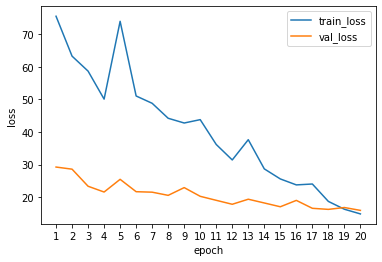

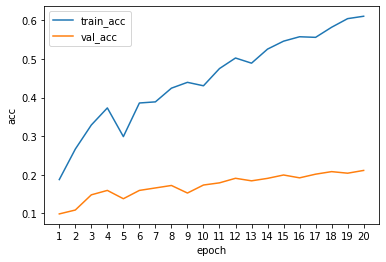

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/hd_300_1.png" 
filename2 = "multi_lstm/hd_300_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(hd_300_tl, hd_300_vl, hd_300_ta, hd_300_va, filename1, filename2, 1)

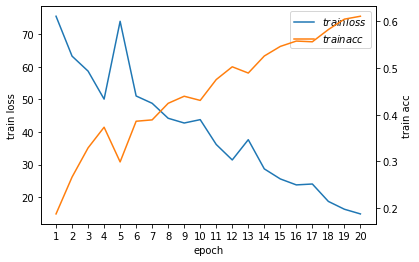

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/hd_300_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], hd_300_tl, hd_300_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = hd_300_pred_test
filename = "multi_lstm/hd_300_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       111   11    5    8   20    5    6   3    0
1        33  211    4    6    8   24    8   8    0
2        14    4  227   14    2    2    6   7    0
3        19    3   13  190   15    3    4  15    0
4        23    5    6   12  206   13   10   5    0
5        11   14    3   14   16  192   25  34    1
6        12    6    2    5   12    9  185  10    0
7         8   11    3    5    7   12   10  60    0
8         0    0    0    0    0    2    0   1  252


accuracy : 73.9%


precision : [0.66, 0.7, 0.82, 0.73, 0.74, 0.62, 0.77, 0.52, 0.99]

macro_ave_precision : 0.73


recall : [0.48, 0.8, 0.86, 0.75, 0.72, 0.73, 0.73, 0.42, 1.0]

macro_recall : 0.72


f1 : [0.55, 0.74, 0.84, 0.74, 0.73, 0.67, 0.75, 0.46, 0.99]

macro_f1 : 0.72



In [ ]:
evals_y_hd_300 = []
evals_y_hd_300.append(hd_300_ta)
evals_y_hd_300.append(hd_300_tl)
evals_y_hd_300.append(hd_300_va)
evals_y_hd_300.append(hd_300_vl)
evals_y_hd_300.append(hd_300_vl)
evals_y_hd_300.append(hd_300_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_hd_300.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_hd_300, f) #保存

## 考察  
20epochの隠れ層の次元50のモデルの訓練誤差は27.45、検証誤差は16.61、汎化誤差は23.08、テストの正解率は66.62%、隠れ層の次元300のモデルの訓練誤差は14.81、検証誤差は15.9、汎化誤差は20.83、テストの正解率は73.9%になった。（隠れ層の次元100のモデルの訓練誤差は14.1、検証誤差は14.62、汎化誤差は19.95、正解率は76.12%）  
隠れ層次元50の結果より隠れ層の次元を小さくしたモデルの方が検証誤差と汎化誤差が訓練誤差を下回る結果となり過学習の抑制の効果があると分かる。隠れ層の次元を大きくしモデル全体のノード数が増えると訓練データに適合され過ぎるので隠れ層の次元は抑えた方がよいと考えられる。隠れ層の次元を小さくすると正解率は落ちるが300次元から20次元に極端に落としたとしてもテストの正解率は10%ほどの下落で抑えられている。ドロップアウトの効果もありテストの正解率に寄与しているためだと考えられる。  
後のハイパパラメータの再調整で汎化誤差、テストの正解率を見て隠れ層の次元は150以下で調整する。

##Lerning rate 0.0001

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-4, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "lr_04.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
lr_04_evals_trainval = train_val_evals
lr_04_evals_test = test_evals
lr_04_pred_test = y_pred_test

lr_04_ta = []
lr_04_tl = []
lr_04_va = []
lr_04_vl = []
for key in lr_04_evals_trainval.keys():
    lr_04_ta.append(lr_04_evals_trainval[key]["train_acc"])
    lr_04_tl.append(lr_04_evals_trainval[key]["train_loss"])
    lr_04_va.append(lr_04_evals_trainval[key]["val_acc"])
    lr_04_vl.append(lr_04_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.0001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 81.27, train_acc: 8.86%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 35.07, val_acc: 4.44%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 81.05, train_acc: 11.29%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 34.98, val_acc: 7.02%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 80.8, train_acc: 12.84%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 34.86, val_acc: 7.23%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 80.49, train_acc: 14.22%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 34.69, val_acc: 7.0%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 79.93, train_acc: 16.16%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 34.38, val_acc: 6.98%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 78.94, train_acc: 16.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 33.62, val_acc: 6.94%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 76.05, train_acc: 18.06%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 31.38, val_acc: 8.4%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 72.01, train_acc: 20.02%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 29.98, val_acc: 9.7%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 69.65, train_acc: 21.63%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 29.67, val_acc: 10.43%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 68.3, train_acc: 22.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 28.94, val_acc: 10.86%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 66.53, train_acc: 22.67%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 28.48, val_acc: 11.35%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 65.95, train_acc: 24.19%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 28.15, val_acc: 11.42%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 64.82, train_acc: 24.73%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 27.62, val_acc: 11.85%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 63.45, train_acc: 25.1%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 27.3, val_acc: 11.91%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 62.84, train_acc: 25.58%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 27.22, val_acc: 12.32%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 62.39, train_acc: 27.02%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 26.61, val_acc: 12.22%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 60.87, train_acc: 27.44%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 26.24, val_acc: 12.53%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 60.64, train_acc: 28.43%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 26.65, val_acc: 11.87%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 59.51, train_acc: 28.43%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 26.05, val_acc: 12.92%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 59.24, train_acc: 28.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 25.92, val_acc: 13.13%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 37.33, test_acc: 42.11%

多クラスの混同行列
y_test   0   1   2    3    4    5   6   7    8
y_pred                                        
0        0   0   1    0    0    0   0   0    0
1       18  51  19    2   12    1  10   3    0
2       34  44  95   11   13   22   7  10    0
3       26  18  28  174   28   35  35  41    0
4       76  69  56   17  162   33  94  16    0
5       49  48  46   30   50  134  45  54    5
6       28  32  18   16   21   27  60   5    0
7        0   0   0    0    0    2   0   7    0
8        0   3   0    4    0    8   3   7  248

elapsed_time:402.01[sec]


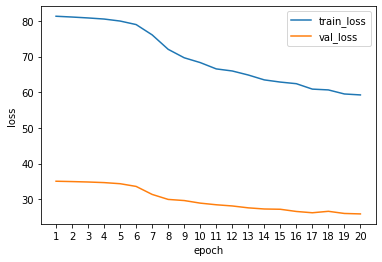

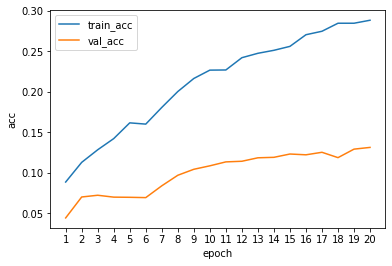

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/lr_04_1.png" 
filename2 = "multi_lstm/lr_04_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(lr_04_tl, lr_04_vl, lr_04_ta, lr_04_va, filename1, filename2, 1)

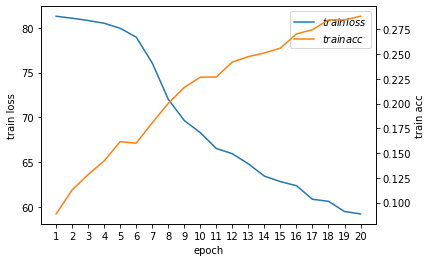

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/lr_04_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], lr_04_tl, lr_04_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = lr_04_pred_test
filename = "multi_lstm/lr_04_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test   0   1   2    3    4    5   6   7    8
y_pred                                        
0        0   0   1    0    0    0   0   0    0
1       18  51  19    2   12    1  10   3    0
2       34  44  95   11   13   22   7  10    0
3       26  18  28  174   28   35  35  41    0
4       76  69  56   17  162   33  94  16    0
5       49  48  46   30   50  134  45  54    5
6       28  32  18   16   21   27  60   5    0
7        0   0   0    0    0    2   0   7    0
8        0   3   0    4    0    8   3   7  248


accuracy : 42.11%


precision : [0.0, 0.44, 0.4, 0.45, 0.31, 0.29, 0.29, 0.78, 0.91]

macro_ave_precision : 0.43


recall : [0.0, 0.19, 0.36, 0.69, 0.57, 0.51, 0.24, 0.05, 0.98]

macro_recall : 0.4


f1 : [0.0, 0.27, 0.38, 0.54, 0.4, 0.37, 0.26, 0.09, 0.94]

macro_f1 : 0.36



In [ ]:
evals_y_lr_04 = []
evals_y_lr_04.append(lr_04_ta)
evals_y_lr_04.append(lr_04_tl)
evals_y_lr_04.append(lr_04_va)
evals_y_lr_04.append(lr_04_vl)
evals_y_lr_04.append(lr_04_vl)
evals_y_lr_04.append(lr_04_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_lr_04.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_lr_04, f) #保存

##Lerning rate 0.01

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.5, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-2, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "lr_02.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
lr_02_evals_trainval = train_val_evals
lr_02_evals_test = test_evals
lr_02_pred_test = y_pred_test

lr_02_ta = []
lr_02_tl = []
lr_02_va = []
lr_02_vl = []
for key in lr_02_evals_trainval.keys():
    lr_02_ta.append(lr_02_evals_trainval[key]["train_acc"])
    lr_02_tl.append(lr_02_evals_trainval[key]["train_loss"])
    lr_02_va.append(lr_02_evals_trainval[key]["val_acc"])
    lr_02_vl.append(lr_02_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.5, 'epochs': 20, 'batch_size': 100, 'lr': 0.01, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 71.02, train_acc: 22.56%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 25.99, val_acc: 13.29%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 49.7, train_acc: 37.88%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 19.36, val_acc: 17.92%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 36.25, train_acc: 47.46%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 17.32, val_acc: 19.41%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 26.17, train_acc: 53.36%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 16.07, val_acc: 20.23%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 28.33, train_acc: 53.22%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 15.85, val_acc: 20.95%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 17.83, train_acc: 59.54%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 17.21, val_acc: 20.42%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 13.02, train_acc: 61.71%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 15.4, val_acc: 22.17%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 7.85, train_acc: 65.55%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 15.28, val_acc: 22.42%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 6.07, train_acc: 66.87%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 17.41, val_acc: 22.42%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 4.84, train_acc: 67.28%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 16.5, val_acc: 22.81%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 3.62, train_acc: 67.96%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 18.73, val_acc: 22.52%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 3.01, train_acc: 68.37%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 19.13, val_acc: 22.91%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 3.25, train_acc: 68.43%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 18.43, val_acc: 22.89%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 2.38, train_acc: 68.74%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 18.86, val_acc: 22.85%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 3.07, train_acc: 68.29%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 23.43, val_acc: 22.38%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 4.02, train_acc: 67.82%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 21.56, val_acc: 22.38%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 4.68, train_acc: 67.61%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 17.72, val_acc: 22.89%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 2.86, train_acc: 68.48%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 19.11, val_acc: 22.54%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 2.29, train_acc: 68.75%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 17.7, val_acc: 22.94%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 1.54, train_acc: 69.26%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 17.77, val_acc: 23.16%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 23.76, test_acc: 79.69%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       170   16    4    4   56    6    4   7    0
1        11  221    5   11    5   10   10   6    0
2         9    1  245   19    2   12    6   8    1
3         3    3    3  203    1    8    4   4    0
4        23    3    2    2  204    3    1   1    0
5         2    3    1    5    2  179   14  22    0
6         6    9    2    4    2   15  202   9    0
7         7    8    1    5   14   26   12  86    0
8         0    1    0    1    0    3    1   0  252

elapsed_time:409.03[sec]


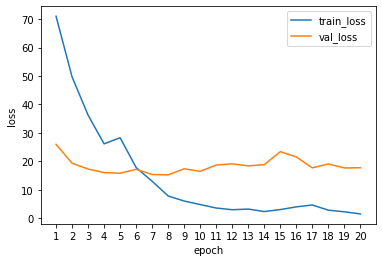

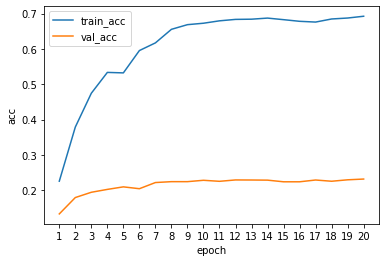

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/lr_02_1.png" 
filename2 = "multi_lstm/lr_02_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(lr_02_tl, lr_02_vl, lr_02_ta, lr_02_va, filename1, filename2, 1)

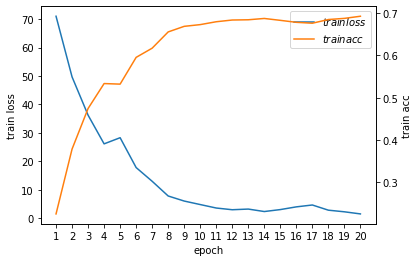

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/lr_02_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], lr_02_tl, lr_02_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = lr_02_pred_test
filename = "multi_lstm/lr_02_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       170   16    4    4   56    6    4   7    0
1        11  221    5   11    5   10   10   6    0
2         9    1  245   19    2   12    6   8    1
3         3    3    3  203    1    8    4   4    0
4        23    3    2    2  204    3    1   1    0
5         2    3    1    5    2  179   14  22    0
6         6    9    2    4    2   15  202   9    0
7         7    8    1    5   14   26   12  86    0
8         0    1    0    1    0    3    1   0  252


accuracy : 79.69%


precision : [0.64, 0.79, 0.81, 0.89, 0.85, 0.79, 0.81, 0.54, 0.98]

macro_ave_precision : 0.79


recall : [0.74, 0.83, 0.93, 0.8, 0.71, 0.68, 0.8, 0.6, 1.0]

macro_recall : 0.79


f1 : [0.68, 0.81, 0.87, 0.84, 0.78, 0.73, 0.8, 0.57, 0.99]

macro_f1 : 0.79



In [ ]:
evals_y_lr_02 = []
evals_y_lr_02.append(lr_02_ta)
evals_y_lr_02.append(lr_02_tl)
evals_y_lr_02.append(lr_02_va)
evals_y_lr_02.append(lr_02_vl)
evals_y_lr_02.append(lr_02_vl)
evals_y_lr_02.append(lr_02_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_lr_02.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_lr_02, f) #保存

## 考察  
20epochの学習率0.01のモデルの訓練誤差は1.54、検証誤差は17.77、汎化誤差は23.76、テストの正解率は79.69%、学習率0.0001のモデルの訓練誤差は59.24、検証誤差は25.92、汎化誤差は37.33、テストの正解率は42.11%になった。（学習率0.001のモデルの訓練誤差は14.1、検証誤差は14.62、汎化誤差は19.95、正解率は76.12%）  
学習率0.01の結果より学習率を大きくすると訓練誤差は1.54に対して汎化誤差は23.76となり過学習に陥っていると分かる。学習率を上げるとパラメータを更新する速度が速くなり訓練誤差がすぐに収束してしまい、訓練データに過剰に適合するのが原因がと考えられる。学習率0.0001の結果より汎化性能を上げようと学習率を落とすと逆に学習が十分に行われなくテストの正解率を著しく下げてしまう。  
後のハイパパラメータの再調整で汎化誤差、テストの正解率を見て学習率は0.01未満で調整する。

##Dropout ratio 0.3

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.3, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "dr_03.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
dr_03_evals_trainval = train_val_evals
dr_03_evals_test = test_evals
dr_03_pred_test = y_pred_test

dr_03_ta = []
dr_03_tl = []
dr_03_va = []
dr_03_vl = []
for key in dr_03_evals_trainval.keys():
    dr_03_ta.append(dr_03_evals_trainval[key]["train_acc"])
    dr_03_tl.append(dr_03_evals_trainval[key]["train_loss"])
    dr_03_va.append(dr_03_evals_trainval[key]["val_acc"])
    dr_03_vl.append(dr_03_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.3, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 77.46, train_acc: 15.88%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 30.02, val_acc: 9.04%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 66.35, train_acc: 25.06%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 29.07, val_acc: 11.81%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 59.18, train_acc: 30.78%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 24.9, val_acc: 13.5%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 54.41, train_acc: 34.23%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 22.8, val_acc: 15.22%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 49.59, train_acc: 37.53%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 21.92, val_acc: 16.29%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 44.94, train_acc: 41.51%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 20.5, val_acc: 16.91%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 42.38, train_acc: 43.62%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 20.14, val_acc: 17.4%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 38.1, train_acc: 46.02%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 18.71, val_acc: 18.43%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 34.36, train_acc: 48.18%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 18.32, val_acc: 18.95%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 31.61, train_acc: 50.64%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 17.12, val_acc: 19.59%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 27.63, train_acc: 53.49%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 16.83, val_acc: 19.76%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 25.45, train_acc: 54.36%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 16.42, val_acc: 20.25%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 23.76, train_acc: 55.51%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 17.71, val_acc: 19.53%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 21.84, train_acc: 56.96%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 16.51, val_acc: 20.85%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 21.04, train_acc: 57.56%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 15.3, val_acc: 21.16%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 18.01, train_acc: 59.56%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 16.0, val_acc: 21.51%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 15.68, train_acc: 61.17%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 15.09, val_acc: 21.84%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 13.79, train_acc: 62.3%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 14.5, val_acc: 22.28%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 11.65, train_acc: 63.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 14.97, val_acc: 22.42%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 10.55, train_acc: 64.08%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 14.71, val_acc: 22.38%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 20.76, test_acc: 75.4%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       159   18    6    5   11   15    6   7    0
1         7  189    4    5    7   11    0   2    0
2         2   12  222    7    1    6    3   7    0
3         5   12   11  194   15    6    4  11    0
4        25   14    6   10  220   10    8  12    0
5        15    7    7    8    5  164   20  20    0
6        12    4    6   11   13   19  193  10    0
7         6    9    1   10   13   27   20  73    0
8         0    0    0    4    1    4    0   1  253

elapsed_time:404.41[sec]


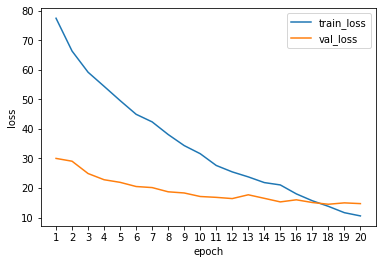

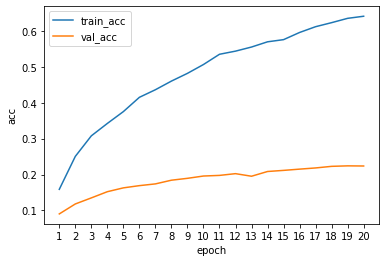

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/dr_03_1.png" 
filename2 = "multi_lstm/dr_03_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(dr_03_tl, dr_03_vl, dr_03_ta, dr_03_va, filename1, filename2, 1)

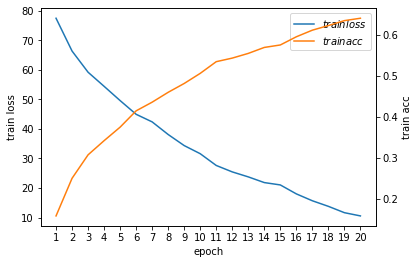

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/dr_03_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], dr_03_tl, dr_03_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = dr_03_pred_test
filename = "multi_lstm/dr_03_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       159   18    6    5   11   15    6   7    0
1         7  189    4    5    7   11    0   2    0
2         2   12  222    7    1    6    3   7    0
3         5   12   11  194   15    6    4  11    0
4        25   14    6   10  220   10    8  12    0
5        15    7    7    8    5  164   20  20    0
6        12    4    6   11   13   19  193  10    0
7         6    9    1   10   13   27   20  73    0
8         0    0    0    4    1    4    0   1  253


accuracy : 75.4%


precision : [0.7, 0.84, 0.85, 0.75, 0.72, 0.67, 0.72, 0.46, 0.96]

macro_ave_precision : 0.74


recall : [0.69, 0.71, 0.84, 0.76, 0.77, 0.63, 0.76, 0.51, 1.0]

macro_recall : 0.74


f1 : [0.69, 0.77, 0.85, 0.76, 0.74, 0.65, 0.74, 0.48, 0.98]

macro_f1 : 0.74



In [ ]:
evals_y_dr_03 = []
evals_y_dr_03.append(dr_03_ta)
evals_y_dr_03.append(dr_03_tl)
evals_y_dr_03.append(dr_03_va)
evals_y_dr_03.append(dr_03_vl)
evals_y_dr_03.append(dr_03_vl)
evals_y_dr_03.append(dr_03_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_dr_03.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_dr_03, f) #保存

##Dropout ratio 0.8

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.8, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 100, #バッチサイズ
    "lr": 1e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 100, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "dr_08.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
dr_08_evals_trainval = train_val_evals
dr_08_evals_test = test_evals
dr_08_pred_test = y_pred_test

dr_08_ta = []
dr_08_tl = []
dr_08_va = []
dr_08_vl = []
for key in dr_08_evals_trainval.keys():
    dr_08_ta.append(dr_08_evals_trainval[key]["train_acc"])
    dr_08_tl.append(dr_08_evals_trainval[key]["train_loss"])
    dr_08_va.append(dr_08_evals_trainval[key]["val_acc"])
    dr_08_vl.append(dr_08_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.8, 'epochs': 20, 'batch_size': 100, 'lr': 0.001, 'embedding_dim': 20, 'hidden_dim': 100, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 80.86, train_acc: 10.59%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, val_loss: 34.56, val_acc: 6.34%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 75.4, train_acc: 17.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, val_loss: 29.34, val_acc: 9.1%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 68.71, train_acc: 22.36%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, val_loss: 27.9, val_acc: 11.54%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 64.38, train_acc: 25.27%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, val_loss: 26.46, val_acc: 11.4%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 66.55, train_acc: 25.93%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, val_loss: 26.91, val_acc: 12.99%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 60.65, train_acc: 30.62%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, val_loss: 24.83, val_acc: 14.57%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 69.08, train_acc: 28.59%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, val_loss: 26.41, val_acc: 14.29%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 58.11, train_acc: 33.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, val_loss: 23.54, val_acc: 15.26%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 52.73, train_acc: 37.18%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, val_loss: 22.47, val_acc: 15.69%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 50.52, train_acc: 38.93%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, val_loss: 22.24, val_acc: 16.12%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 47.76, train_acc: 40.65%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, val_loss: 21.22, val_acc: 17.46%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 44.37, train_acc: 43.23%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, val_loss: 19.16, val_acc: 18.13%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 40.45, train_acc: 45.69%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, val_loss: 18.63, val_acc: 18.81%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 37.7, train_acc: 47.92%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, val_loss: 18.83, val_acc: 19.01%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 35.1, train_acc: 49.81%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, val_loss: 17.37, val_acc: 19.86%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 34.05, train_acc: 50.21%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, val_loss: 17.15, val_acc: 19.9%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 31.9, train_acc: 52.39%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, val_loss: 16.18, val_acc: 20.64%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 29.97, train_acc: 53.37%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, val_loss: 16.02, val_acc: 20.93%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 29.13, train_acc: 55.02%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, val_loss: 19.75, val_acc: 19.51%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 38.18, train_acc: 48.39%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, val_loss: 16.54, val_acc: 20.95%


-------------------------テスト-------------------------


  0%|          | 0/23 [00:00<?, ?it/s]

test_loss: 24.82, test_acc: 69.52%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       141    8    0    4    2    4    3   3    0
1        28  163    9   12   14   12    4  11    1
2         3   20  215   10    4   18    8  11   13
3         1    6    1  151    5    4    5   5    6
4        37   27    9   33  233   13   13  15    3
5         6   20   16   14    2  176   20  25   21
6        12    8   10   20   19   32  197  19    1
7         3   11    3    9    7    2    3  53    0
8         0    2    0    1    0    1    1   1  208

elapsed_time:402.91[sec]


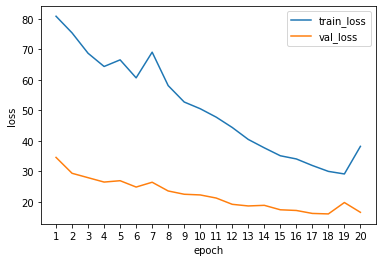

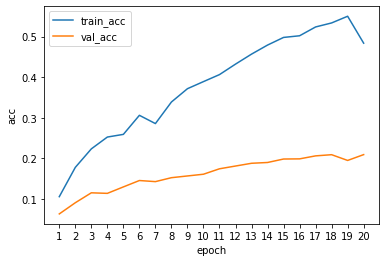

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/dr_08_1.png" 
filename2 = "multi_lstm/dr_08_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(dr_08_tl, dr_08_vl, dr_08_ta, dr_08_va, filename1, filename2, 1)

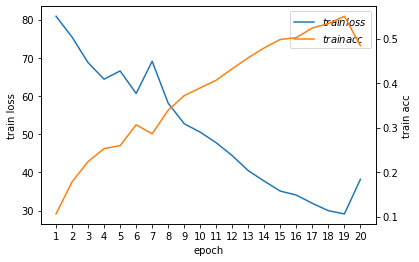

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/dr_08_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], dr_08_tl, dr_08_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = dr_08_pred_test
filename = "multi_lstm/dr_08_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       141    8    0    4    2    4    3   3    0
1        28  163    9   12   14   12    4  11    1
2         3   20  215   10    4   18    8  11   13
3         1    6    1  151    5    4    5   5    6
4        37   27    9   33  233   13   13  15    3
5         6   20   16   14    2  176   20  25   21
6        12    8   10   20   19   32  197  19    1
7         3   11    3    9    7    2    3  53    0
8         0    2    0    1    0    1    1   1  208


accuracy : 69.52%


precision : [0.85, 0.64, 0.71, 0.82, 0.61, 0.59, 0.62, 0.58, 0.97]

macro_ave_precision : 0.71


recall : [0.61, 0.62, 0.82, 0.59, 0.81, 0.67, 0.78, 0.37, 0.82]

macro_recall : 0.68


f1 : [0.71, 0.63, 0.76, 0.69, 0.7, 0.63, 0.69, 0.45, 0.89]

macro_f1 : 0.68



In [ ]:
evals_y_dr_08 = []
evals_y_dr_08.append(dr_08_ta)
evals_y_dr_08.append(dr_08_tl)
evals_y_dr_08.append(dr_08_va)
evals_y_dr_08.append(dr_08_vl)
evals_y_dr_08.append(dr_08_vl)
evals_y_dr_08.append(dr_08_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_dr_08.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_dr_08, f) #保存

## 考察  
20epochのドロップアウトレシオ（ドロップアウトでノードをマスクする割合）0.3のモデルの訓練誤差は10.55、検証誤差は14.71、汎化誤差は20.76、テストの正解率は75.4%、ドロップアウトレシオ0.8のモデルの訓練誤差は38.18、検証誤差は16.54、汎化誤差は24.82、テストの正解率は69.52%になった。（ドロップアウトレシオ0.5のモデルの訓練誤差は14.1、検証誤差は14.62、汎化誤差は19.95、正解率は76.12%）  
ドロップアウトレシオ0.8の結果より検証誤差、汎化誤差が訓練誤差を下回っていることからドロップアウトレシオを大きくすると過学習を抑えられると分かる。ドロップアウトを大きくしても正解率は70%付近に留まり、大きく値を落とさないようである。学習ステップごとにランダムにノードをマスクし疑似的に複数の異なるモデルを再現し結果的にアンサンブル効果を得ていることから汎化性能に寄与していると考えられる。  
後のハイパパラメータの再調整で汎化誤差、テストの正解率を見てドロップアウトレシオは0.5以上で調整する。

# ハイパパラメータの再調整  
実験の結果を踏まえてハイパパラメータを再調整する。
- 二層のLSTMでドロップアウトあり  
- バッチサイズ：100以上
- 埋め込み層の次元：50以下
- 隠れ層の次元: 150以下
- 学習率： 0.01未満
- ドロップアウトレシオ：0.5以上

## テスト1  
バッチサイズ：150、埋め込み層の次元：20、隠れ層の次元:120、学習率：0.0008、ドロップアウトレシオ：0.6

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.6, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 150, #バッチサイズ
    "lr": 0.8e-3, #学習率
    "embedding_dim": 20, #埋め込み層の次元
    "hidden_dim": 120, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "adj_01.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
adj_01_evals_trainval = train_val_evals
adj_01_evals_test = test_evals
adj_01_pred_test = y_pred_test

adj_01_ta = []
adj_01_tl = []
adj_01_va = []
adj_01_vl = []
for key in adj_01_evals_trainval.keys():
    adj_01_ta.append(adj_01_evals_trainval[key]["train_acc"])
    adj_01_tl.append(adj_01_evals_trainval[key]["train_loss"])
    adj_01_va.append(adj_01_evals_trainval[key]["val_acc"])
    adj_01_vl.append(adj_01_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.6, 'epochs': 20, 'batch_size': 150, 'lr': 0.0008, 'embedding_dim': 20, 'hidden_dim': 120, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 54.36, train_acc: 12.84%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1, val_loss: 23.12, val_acc: 6.07%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 50.16, train_acc: 18.54%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2, val_loss: 23.86, val_acc: 9.48%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 48.55, train_acc: 21.3%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3, val_loss: 19.91, val_acc: 10.92%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 44.58, train_acc: 24.28%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4, val_loss: 18.82, val_acc: 11.89%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 41.89, train_acc: 27.11%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5, val_loss: 18.35, val_acc: 12.34%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 39.18, train_acc: 30.37%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 6, val_loss: 17.39, val_acc: 12.94%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 38.62, train_acc: 32.18%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 7, val_loss: 16.75, val_acc: 14.1%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 35.57, train_acc: 35.12%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 8, val_loss: 15.54, val_acc: 15.13%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 32.93, train_acc: 37.88%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9, val_loss: 15.6, val_acc: 15.38%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 30.99, train_acc: 39.55%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10, val_loss: 14.44, val_acc: 16.33%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 29.7, train_acc: 41.21%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11, val_loss: 14.72, val_acc: 16.06%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 28.02, train_acc: 43.39%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12, val_loss: 13.74, val_acc: 17.18%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 25.58, train_acc: 45.54%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13, val_loss: 13.54, val_acc: 17.79%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 25.01, train_acc: 47.15%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14, val_loss: 13.08, val_acc: 18.56%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 22.33, train_acc: 49.61%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 15, val_loss: 12.73, val_acc: 18.81%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 27.54, train_acc: 45.69%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 16, val_loss: 13.2, val_acc: 18.23%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 22.9, train_acc: 49.36%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17, val_loss: 12.05, val_acc: 19.47%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 19.73, train_acc: 52.42%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 18, val_loss: 12.08, val_acc: 19.94%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 19.0, train_acc: 53.36%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 19, val_loss: 11.69, val_acc: 19.96%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 16.95, train_acc: 55.57%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 20, val_loss: 11.73, val_acc: 20.11%


-------------------------テスト-------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

test_loss: 15.32, test_acc: 67.89%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       132   22    5   10   36   15    8   7    0
1        39  173   36   16    8   20    8  12    0
2         3   20  191    2    1   14    0   2    1
3         2    3    5  170    8   14   13  10    1
4        29   13    7   11  198   11   11   9    0
5         9   19   10   12    8  141   14  31    6
6        14    7    6   19   14   27  192  10    2
7         3    7    3   13   13   20    7  61    0
8         0    1    0    1    0    0    1   1  243

elapsed_time:369.72[sec]


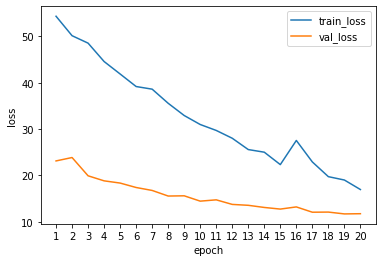

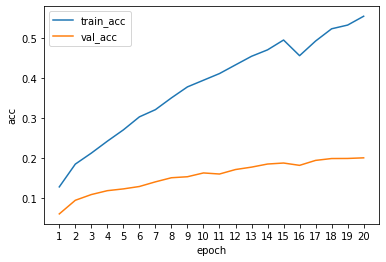

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/adj_01_1.png" 
filename2 = "multi_lstm/adj_01_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(adj_01_tl, adj_01_vl, adj_01_ta, adj_01_va, filename1, filename2, 1)

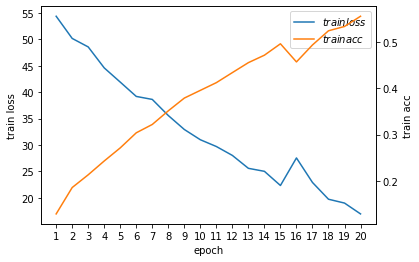

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/adj_01_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], adj_01_tl, adj_01_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = adj_01_pred_test
filename = "multi_lstm/adj_01_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       132   22    5   10   36   15    8   7    0
1        39  173   36   16    8   20    8  12    0
2         3   20  191    2    1   14    0   2    1
3         2    3    5  170    8   14   13  10    1
4        29   13    7   11  198   11   11   9    0
5         9   19   10   12    8  141   14  31    6
6        14    7    6   19   14   27  192  10    2
7         3    7    3   13   13   20    7  61    0
8         0    1    0    1    0    0    1   1  243


accuracy : 67.89%


precision : [0.56, 0.55, 0.82, 0.75, 0.69, 0.56, 0.66, 0.48, 0.98]

macro_ave_precision : 0.67


recall : [0.57, 0.65, 0.73, 0.67, 0.69, 0.54, 0.76, 0.43, 0.96]

macro_recall : 0.67


f1 : [0.57, 0.6, 0.77, 0.71, 0.69, 0.55, 0.7, 0.45, 0.97]

macro_f1 : 0.67



In [ ]:
evals_y_adj_01 = []
evals_y_adj_01.append(adj_01_ta)
evals_y_adj_01.append(adj_01_tl)
evals_y_adj_01.append(adj_01_va)
evals_y_adj_01.append(adj_01_vl)
evals_y_adj_01.append(adj_01_vl)
evals_y_adj_01.append(adj_01_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_adj_01.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_adj_01, f) #保存

## テスト2  
バッチサイズ：150、埋め込み層の次元：15、隠れ層の次元:150、学習率：0.0008、ドロップアウトレシオ：0.6

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.6, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 150, #バッチサイズ
    "lr": 0.8e-3, #学習率
    "embedding_dim": 15, #埋め込み層の次元
    "hidden_dim": 150, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "adj_02.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
adj_02_evals_trainval = train_val_evals
adj_02_evals_test = test_evals
adj_02_pred_test = y_pred_test

adj_02_ta = []
adj_02_tl = []
adj_02_va = []
adj_02_vl = []
for key in adj_02_evals_trainval.keys():
    adj_02_ta.append(adj_02_evals_trainval[key]["train_acc"])
    adj_02_tl.append(adj_02_evals_trainval[key]["train_loss"])
    adj_02_va.append(adj_02_evals_trainval[key]["val_acc"])
    adj_02_vl.append(adj_02_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.6, 'epochs': 20, 'batch_size': 150, 'lr': 0.0008, 'embedding_dim': 15, 'hidden_dim': 150, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 54.43, train_acc: 12.02%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1, val_loss: 23.3, val_acc: 4.44%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 51.81, train_acc: 18.13%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2, val_loss: 21.71, val_acc: 8.61%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 54.08, train_acc: 13.93%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3, val_loss: 22.27, val_acc: 8.57%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 47.86, train_acc: 23.35%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4, val_loss: 19.7, val_acc: 12.26%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 42.99, train_acc: 26.84%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5, val_loss: 18.41, val_acc: 11.23%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 40.21, train_acc: 30.45%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 6, val_loss: 17.11, val_acc: 13.13%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 37.39, train_acc: 32.49%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 7, val_loss: 16.22, val_acc: 14.18%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 35.52, train_acc: 35.74%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 8, val_loss: 16.06, val_acc: 13.91%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 33.18, train_acc: 37.3%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9, val_loss: 15.53, val_acc: 15.11%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 31.25, train_acc: 39.41%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10, val_loss: 14.77, val_acc: 15.73%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 29.57, train_acc: 41.39%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11, val_loss: 13.78, val_acc: 17.07%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 27.62, train_acc: 43.39%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12, val_loss: 13.48, val_acc: 17.24%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 26.47, train_acc: 45.5%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13, val_loss: 13.15, val_acc: 17.59%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 25.27, train_acc: 47.77%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14, val_loss: 13.13, val_acc: 18.08%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 23.27, train_acc: 48.43%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 15, val_loss: 12.18, val_acc: 18.91%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 21.28, train_acc: 50.41%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 16, val_loss: 12.76, val_acc: 18.46%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 21.08, train_acc: 50.7%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17, val_loss: 11.74, val_acc: 19.32%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 19.09, train_acc: 53.28%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 18, val_loss: 11.4, val_acc: 19.67%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 19.37, train_acc: 52.89%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 19, val_loss: 11.34, val_acc: 19.88%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 16.05, train_acc: 55.43%


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 20, val_loss: 10.83, val_acc: 20.71%


-------------------------テスト-------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

test_loss: 14.02, test_acc: 70.06%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       157   12   11   15   26   14   12   5    0
1        20  176    8    8    4   32    4  13    0
2         2    5  222   30    0    0    1   4    0
3         2    4    5  157    4    3    8  12    0
4        35   12    6   11  213   14   14   7    1
5         6   40    1   16   16  157   41  35    0
6         8   11    9   12   22   33  172  24    0
7         1    5    1    5    1    9    2  43    0
8         0    0    0    0    0    0    0   0  252

elapsed_time:498.59[sec]


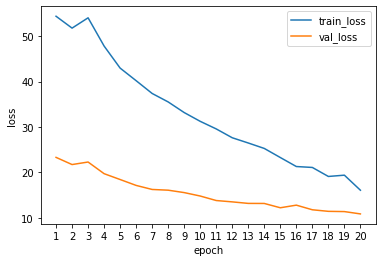

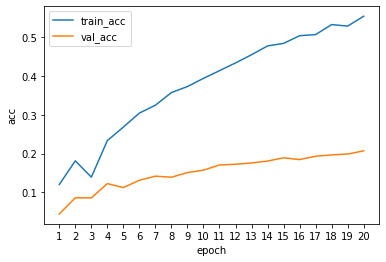

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/adj_02_1.png" 
filename2 = "multi_lstm/adj_02_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(adj_02_tl, adj_02_vl, adj_02_ta, adj_02_va, filename1, filename2, 1)

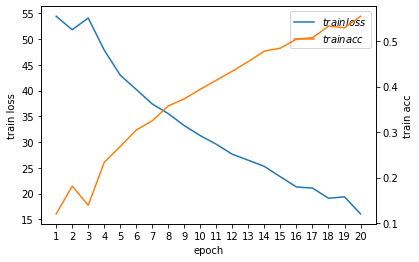

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/adj_02_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], adj_02_tl, adj_02_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = adj_02_pred_test
filename = "multi_lstm/adj_02_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       157   12   11   15   26   14   12   5    0
1        20  176    8    8    4   32    4  13    0
2         2    5  222   30    0    0    1   4    0
3         2    4    5  157    4    3    8  12    0
4        35   12    6   11  213   14   14   7    1
5         6   40    1   16   16  157   41  35    0
6         8   11    9   12   22   33  172  24    0
7         1    5    1    5    1    9    2  43    0
8         0    0    0    0    0    0    0   0  252


accuracy : 70.06%


precision : [0.62, 0.66, 0.84, 0.81, 0.68, 0.5, 0.59, 0.64, 1.0]

macro_ave_precision : 0.7


recall : [0.68, 0.66, 0.84, 0.62, 0.74, 0.6, 0.68, 0.3, 1.0]

macro_recall : 0.68


f1 : [0.65, 0.66, 0.84, 0.7, 0.71, 0.55, 0.63, 0.41, 1.0]

macro_f1 : 0.68



In [ ]:
evals_y_adj_02 = []
evals_y_adj_02.append(adj_02_ta)
evals_y_adj_02.append(adj_02_tl)
evals_y_adj_02.append(adj_02_va)
evals_y_adj_02.append(adj_02_vl)
evals_y_adj_02.append(adj_02_vl)
evals_y_adj_02.append(adj_02_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_adj_02.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_adj_02, f) #保存

## テスト3  
バッチサイズ：200、埋め込み層の次元：18、隠れ層の次元:180、学習率：0.0008、ドロップアウトレシオ：0.6

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.6, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 200, #バッチサイズ
    "lr": 0.8e-3, #学習率
    "embedding_dim": 18, #埋め込み層の次元
    "hidden_dim": 180, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "adj_03.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
adj_03_evals_trainval = train_val_evals
adj_03_evals_test = test_evals
adj_03_pred_test = y_pred_test

adj_03_ta = []
adj_03_tl = []
adj_03_va = []
adj_03_vl = []
for key in adj_03_evals_trainval.keys():
    adj_03_ta.append(adj_03_evals_trainval[key]["train_acc"])
    adj_03_tl.append(adj_03_evals_trainval[key]["train_loss"])
    adj_03_va.append(adj_03_evals_trainval[key]["val_acc"])
    adj_03_vl.append(adj_03_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.6, 'epochs': 20, 'batch_size': 200, 'lr': 0.0008, 'embedding_dim': 18, 'hidden_dim': 180, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 41.42, train_acc: 11.56%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1, val_loss: 17.17, val_acc: 6.4%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 40.05, train_acc: 18.77%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2, val_loss: 15.63, val_acc: 10.76%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 36.1, train_acc: 23.97%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3, val_loss: 14.36, val_acc: 10.65%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 33.0, train_acc: 26.11%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4, val_loss: 13.63, val_acc: 11.6%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 31.09, train_acc: 28.2%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5, val_loss: 12.97, val_acc: 11.77%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 30.26, train_acc: 30.49%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6, val_loss: 12.42, val_acc: 13.83%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 28.4, train_acc: 32.64%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7, val_loss: 13.21, val_acc: 12.43%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 29.49, train_acc: 32.53%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8, val_loss: 12.01, val_acc: 14.02%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 31.73, train_acc: 33.18%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9, val_loss: 13.94, val_acc: 13.3%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 33.9, train_acc: 26.24%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10, val_loss: 14.19, val_acc: 10.92%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 29.63, train_acc: 33.28%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11, val_loss: 11.86, val_acc: 14.93%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 25.22, train_acc: 38.83%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12, val_loss: 10.79, val_acc: 15.75%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 23.33, train_acc: 41.0%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13, val_loss: 10.78, val_acc: 16.14%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 23.81, train_acc: 40.21%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14, val_loss: 10.92, val_acc: 16.21%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 22.44, train_acc: 43.85%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15, val_loss: 10.2, val_acc: 17.36%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 21.15, train_acc: 44.36%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16, val_loss: 9.83, val_acc: 18.04%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 19.06, train_acc: 47.05%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17, val_loss: 9.48, val_acc: 18.37%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 18.07, train_acc: 48.12%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18, val_loss: 8.9, val_acc: 18.99%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 16.33, train_acc: 50.04%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19, val_loss: 9.73, val_acc: 18.29%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 15.6, train_acc: 51.44%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20, val_loss: 8.22, val_acc: 19.8%


-------------------------テスト-------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

test_loss: 11.95, test_acc: 68.66%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       176   50    6    6   12   15    8   1    0
1         3  112    9    2    4   11    2  11    0
2         5    4  222   32    7    4   14  11    0
3         4   10   10  161    6   10    7   3    0
4        24   35    5   13  233   27   15  14    0
5         6   29    5   10    9  150   31  47    1
6        11   15    6   19   12   27  170  14    0
7         0    7    0   11    0   13    6  42    0
8         2    3    0    0    3    5    1   0  252

elapsed_time:410.97[sec]


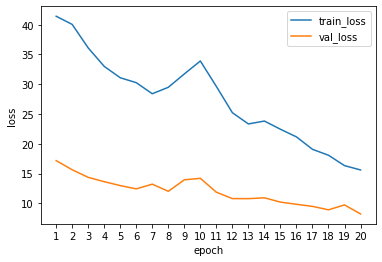

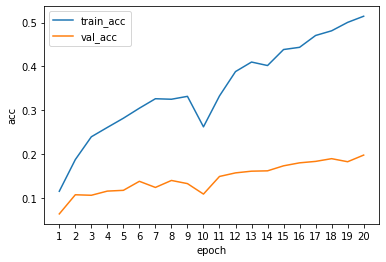

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/adj_03_1.png" 
filename2 = "multi_lstm/adj_03_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(adj_03_tl, adj_03_vl, adj_03_ta, adj_03_va, filename1, filename2, 1)

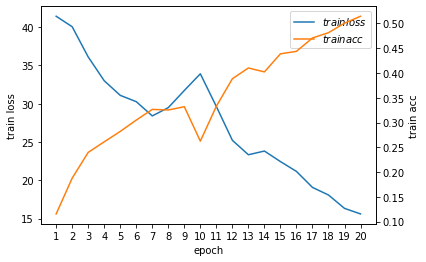

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/adj_03_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], adj_03_tl, adj_03_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = adj_03_pred_test
filename = "multi_lstm/adj_03_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       176   50    6    6   12   15    8   1    0
1         3  112    9    2    4   11    2  11    0
2         5    4  222   32    7    4   14  11    0
3         4   10   10  161    6   10    7   3    0
4        24   35    5   13  233   27   15  14    0
5         6   29    5   10    9  150   31  47    1
6        11   15    6   19   12   27  170  14    0
7         0    7    0   11    0   13    6  42    0
8         2    3    0    0    3    5    1   0  252


accuracy : 68.66%


precision : [0.64, 0.73, 0.74, 0.76, 0.64, 0.52, 0.62, 0.53, 0.95]

macro_ave_precision : 0.68


recall : [0.76, 0.42, 0.84, 0.63, 0.81, 0.57, 0.67, 0.29, 1.0]

macro_recall : 0.67


f1 : [0.7, 0.53, 0.79, 0.69, 0.71, 0.55, 0.64, 0.38, 0.97]

macro_f1 : 0.66



In [ ]:
evals_y_adj_03 = []
evals_y_adj_03.append(adj_03_ta)
evals_y_adj_03.append(adj_03_tl)
evals_y_adj_03.append(adj_03_va)
evals_y_adj_03.append(adj_03_vl)
evals_y_adj_03.append(adj_03_vl)
evals_y_adj_03.append(adj_03_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_adj_03.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_adj_03, f) #保存

## テスト4
バッチサイズ：200、埋め込み層の次元：25、隠れ層の次元:180、
学習率：0.0008、ドロップアウトレシオ：0.6

In [ ]:
#ハイパパラメータの宣言
params = {
    "lstm_flg": True, #単層か2層のLSTMのスイッチ
    "dropout_flg": True ,#dropoutのスイッチ
    "dropout_ratio": 0.6, #dropoutの割合
    "epochs": 20, #エポック数
    "batch_size": 200, #バッチサイズ
    "lr": 0.8e-3, #学習率
    "embedding_dim": 25, #埋め込み層の次元
    "hidden_dim": 180, #隠れ層の次元
    "vocab_size": len(word2index), #全単語数
    "tag_size": len(categories), #ラベルの個数
    "test_size": test_size, #テスト用データに割り振る割合
    "val_size": val_size #検証用に割り振る割合
}

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import time

start_time = time.time()
train_loss = []  #訓練誤差を格納
train_acc = []  #テストでの正解率を格納
val_loss = []  #検証誤差を格納
val_acc = []  #検証での正解率を格納
train_val_evals = {}  #訓練と検証の指標をまとめる
train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)  #DataLoaderのsamplerを用いてランダムにデータを抽出
val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=train_subsampler, pin_memory=True,
                    num_workers=2)  #pin_memmoryとnum_workersを設定しモデル学習を高速化。
val_loader = torch.utils.data.DataLoader(
                    trainval_dataset, batch_size=params["batch_size"],
                    sampler=val_subsampler, pin_memory=True,
                    num_workers=2)
model = LSTMClassifier(**params).to(device)  #モデルのインスタンス化およびGPUへ送る
loss_function = nn.NLLLoss()  #損失関数
optimizer = optim.Adam(model.parameters(), lr=params["lr"])  #Adamによる最適化
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_results/multi_lstm/"  #保存先のパス
filename = "adj_04.txt"  #ファイル名
fullpath = prepath + filename
with open(fullpath, "w") as f:
    print("LSTMモデルの学習およびテスト結果\n")
    print("LSTMモデルの学習およびテスト結果\n", file=f)
    print("ハイパパラメータ\n{}\n".format(params))
    print("ハイパパラメータ\n{}\n".format(params), file=f)
    print("\n-------------------------学習-------------------------")
    print("\n-------------------------学習-------------------------", file=f)

#訓練と検証
for epoch in tqdm(range(params["epochs"])):
    with open(fullpath, "a") as f:
        print("-------------------------{}epoch-------------------------".format(epoch+1))
        print("-------------------------{}epoch-------------------------".format(epoch+1), file=f)
        train_val()
#テスト
test_evals = {} #指標を格納
y_pred_test = {} #予測値と真値の格納　
test_loader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=params["batch_size"])
test_loss = []  #テスト誤差を格納
test_acc = []  #テストでの正解率を格納
y_batch_total = []  #真値を格納
y_pred_total = []  #モデルの出力値を格納
with open(fullpath, "a") as f:
    print("\n-------------------------テスト-------------------------".format(epoch+1))
    print("\n-------------------------テスト-------------------------".format(epoch+1), file=f)
    test()
    elapsed_time = time.time() - start_time #処理時間を計測
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]")
    print("\nelapsed_time:{}".format(round(elapsed_time, 2)) + "[sec]", file=f)
adj_04_evals_trainval = train_val_evals
adj_04_evals_test = test_evals
adj_04_pred_test = y_pred_test

adj_04_ta = []
adj_04_tl = []
adj_04_va = []
adj_04_vl = []
for key in adj_04_evals_trainval.keys():
    adj_04_ta.append(adj_04_evals_trainval[key]["train_acc"])
    adj_04_tl.append(adj_04_evals_trainval[key]["train_loss"])
    adj_04_va.append(adj_04_evals_trainval[key]["val_acc"])
    adj_04_vl.append(adj_04_evals_trainval[key]["val_loss"])

LSTMモデルの学習およびテスト結果

ハイパパラメータ
{'lstm_flg': True, 'dropout_flg': True, 'dropout_ratio': 0.6, 'epochs': 20, 'batch_size': 200, 'lr': 0.0008, 'embedding_dim': 25, 'hidden_dim': 180, 'vocab_size': 79972, 'tag_size': 9, 'test_size': 0.3, 'val_size': 0.3}


-------------------------学習-------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

-------------------------1epoch-------------------------
Epoch: 1, train_loss: 41.38, train_acc: 13.73%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1, val_loss: 16.98, val_acc: 8.24%

-------------------------2epoch-------------------------
Epoch: 2, train_loss: 37.35, train_acc: 20.33%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2, val_loss: 14.64, val_acc: 9.99%

-------------------------3epoch-------------------------
Epoch: 3, train_loss: 32.71, train_acc: 25.89%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3, val_loss: 13.54, val_acc: 11.6%

-------------------------4epoch-------------------------
Epoch: 4, train_loss: 29.58, train_acc: 29.33%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4, val_loss: 12.49, val_acc: 12.61%

-------------------------5epoch-------------------------
Epoch: 5, train_loss: 28.56, train_acc: 32.14%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5, val_loss: 11.73, val_acc: 14.37%

-------------------------6epoch-------------------------
Epoch: 6, train_loss: 26.66, train_acc: 35.63%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6, val_loss: 11.36, val_acc: 14.99%

-------------------------7epoch-------------------------
Epoch: 7, train_loss: 25.93, train_acc: 38.21%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7, val_loss: 11.28, val_acc: 14.91%

-------------------------8epoch-------------------------
Epoch: 8, train_loss: 23.75, train_acc: 39.97%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8, val_loss: 10.28, val_acc: 16.45%

-------------------------9epoch-------------------------
Epoch: 9, train_loss: 21.91, train_acc: 42.98%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9, val_loss: 9.95, val_acc: 17.46%

-------------------------10epoch-------------------------
Epoch: 10, train_loss: 20.25, train_acc: 45.48%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10, val_loss: 9.43, val_acc: 17.86%

-------------------------11epoch-------------------------
Epoch: 11, train_loss: 19.81, train_acc: 46.63%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11, val_loss: 9.29, val_acc: 18.04%

-------------------------12epoch-------------------------
Epoch: 12, train_loss: 18.71, train_acc: 47.03%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12, val_loss: 9.34, val_acc: 18.6%

-------------------------13epoch-------------------------
Epoch: 13, train_loss: 16.9, train_acc: 50.35%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13, val_loss: 8.66, val_acc: 19.01%

-------------------------14epoch-------------------------
Epoch: 14, train_loss: 15.83, train_acc: 51.03%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14, val_loss: 7.95, val_acc: 20.17%

-------------------------15epoch-------------------------
Epoch: 15, train_loss: 14.89, train_acc: 53.04%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15, val_loss: 8.16, val_acc: 19.55%

-------------------------16epoch-------------------------
Epoch: 16, train_loss: 19.63, train_acc: 50.27%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16, val_loss: 8.04, val_acc: 20.62%

-------------------------17epoch-------------------------
Epoch: 17, train_loss: 13.15, train_acc: 55.35%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17, val_loss: 7.46, val_acc: 20.87%

-------------------------18epoch-------------------------
Epoch: 18, train_loss: 12.53, train_acc: 56.42%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18, val_loss: 8.93, val_acc: 19.28%

-------------------------19epoch-------------------------
Epoch: 19, train_loss: 14.05, train_acc: 53.32%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19, val_loss: 8.61, val_acc: 20.29%

-------------------------20epoch-------------------------
Epoch: 20, train_loss: 11.89, train_acc: 57.29%


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20, val_loss: 6.83, val_acc: 22.05%


-------------------------テスト-------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

test_loss: 9.91, test_acc: 74.99%

多クラスの混同行列
y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       181    8    0    1    3    2    1   1    0
1        15  163   22   14   12   11    6   8    0
2         1    8  218    7    2    0    3   2    0
3         0   10    3  174    0   10    4   8    0
4        20   31    7    9  240   16   16  13    0
5         6   25    2   15   12  176   23  30    4
6         5   13    8   20   17   23  189  13    0
7         2    7    3   14    0   24   12  68    0
8         1    0    0    0    0    0    0   0  249

elapsed_time:411.65[sec]


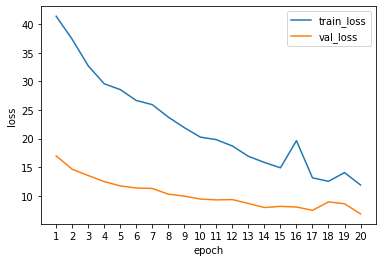

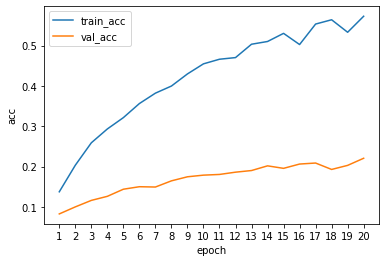

In [ ]:
#訓練と検証それぞれの損失を可視化
filename1 = "multi_lstm/adj_04_1.png" 
filename2 = "multi_lstm/adj_04_2.png"
save_flg = 1 # 保存は1とする。

SetGragh().run(adj_04_tl, adj_04_vl, adj_04_ta, adj_04_va, filename1, filename2, 1)

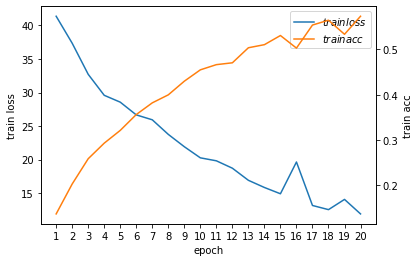

In [ ]:
#訓練の損失と正解率を可視化
filename = "multi_lstm/adj_04_3.png"
save_flg = 1
SetGragh2().run(params["epochs"], adj_04_tl, adj_04_ta, filename, save_flg)

In [ ]:
#テストの混同行列を表示
pred_test = adj_04_pred_test
filename = "multi_lstm/adj_04_4.txt"
save_flg = 1

MultiClassEval(pred_test, filename, save_flg).run()

多クラスの混同行列

y_test    0    1    2    3    4    5    6   7    8
y_pred                                            
0       181    8    0    1    3    2    1   1    0
1        15  163   22   14   12   11    6   8    0
2         1    8  218    7    2    0    3   2    0
3         0   10    3  174    0   10    4   8    0
4        20   31    7    9  240   16   16  13    0
5         6   25    2   15   12  176   23  30    4
6         5   13    8   20   17   23  189  13    0
7         2    7    3   14    0   24   12  68    0
8         1    0    0    0    0    0    0   0  249


accuracy : 74.99%


precision : [0.92, 0.65, 0.9, 0.83, 0.68, 0.6, 0.66, 0.52, 1.0]

macro_ave_precision : 0.75


recall : [0.78, 0.62, 0.83, 0.69, 0.84, 0.67, 0.74, 0.48, 0.98]

macro_recall : 0.74


f1 : [0.85, 0.63, 0.87, 0.75, 0.75, 0.63, 0.7, 0.5, 0.99]

macro_f1 : 0.74



In [ ]:
evals_y_adj_04 = []
evals_y_adj_04.append(adj_04_ta)
evals_y_adj_04.append(adj_04_tl)
evals_y_adj_04.append(adj_04_va)
evals_y_adj_04.append(adj_04_vl)
evals_y_adj_04.append(adj_04_vl)
evals_y_adj_04.append(adj_04_pred_test)

In [ ]:
import pickle
prepath = "/content/gdrive/My Drive/AVILEN/e/product_ensyu/Submission/submission_assignment/save_evals/"
filename = "multi_lstm/evals_y_adj_04.pkl"
fullpath = prepath + filename
with open(fullpath, "wb") as f:
    pickle.dump(evals_y_adj_04, f) #保存

## 結果
- テスト1(バッチサイズ：150、埋め込み層の次元：20、隠れ層の次元:120、学習率：0.0008、ドロップアウトレシオ：0.6)  
20epochでの訓練誤差は16.95、検証誤差は11.73、汎化誤差は15.32、テストの正解率は67.89%
- テスト2(バッチサイズ：150、埋め込み層の次元：15、隠れ層の次元:150、学習率：0.0008、ドロップアウトレシオ：0.6)  
20epochでの訓練誤差は16.05、検証誤差は10.83、汎化誤差は14.02、テストの正解率は70.06%  
- テスト3(バッチサイズ：200、埋め込み層の次元：18、隠れ層の次元:180、学習率：0.0008、ドロップアウトレシオ：0.6)  
20epochでの訓練誤差は15.6、検証誤差は8.22、汎化誤差は11.95、テストの正解率は68.66%
- テスト4(バッチサイズ：200、埋め込み層の次元：25、隠れ層の次元:180、 学習率：0.0008、ドロップアウトレシオ：0.6)  
20epochでの訓練誤差は11.89、検証誤差は6.83、汎化誤差は9.91、テストの正解率は74.99%  
  
バッチサイズを大きくし埋め込み層の次元、隠れ層の次元を合わせて大きくすると、訓練誤差よりも汎化誤差を小さくさせつつ、テストの正解率を75%台まで大きくすることが可能だと分かった。使用するGPUのメモリの制限があり学習することができなかったが、バッチサイズ300以上にして埋め込み層の次元、隠れ層の次元をより大きくすることで汎化性能を高めることが予測できる。

# 精度向上のための調査
コーパスのデータをより多く取集してデータ量によりモデルの精度を上げていく方法が考えられる。バッチデータはpytrochの機能より単純にランダムで選んだが、バッチごとにクラスの偏りがある可能性があり平準化することでモデルの学習向上に寄与すると考えられる。今回の実験では使用しなかったが重みの初期化なども考慮に加えたモデルを適用すればより詳細にデータを捉えることができると考えられる。以下に参考として載せる。
今回はLSTMのモデルで学習を行ったが、自然言語処理の多クラス分類タスクではその他にもCNNやself-attention,BERTを用いた方法なども有名である。特にBERTは膨大なコーパスをもとに作られた事前学習済みモデルでファインチューニングすれば精度の高いモデルの実現が期待できることが報告されている。

In [ ]:
#重みを初期化を考慮したモデル（参考）

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#GPUで並列化処理による高速化。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#LSTM分類器クラスの宣言
#ハイパパラメータは辞書で宣言
class LSTMClassifier(nn.Module):
    #各層の宣言　6層
    def __init__(self, **params):
        super(LSTMClassifier, self).__init__()
        
        #埋め込み層の次元の宣言
        self.word_embeddings = nn.Embedding(params["vocab_size"], params["embedding_dim"], padding_idx=0)
        #dropout
        self.dropout1 = nn.Dropout(params["dropout"])
        #lstmのインスタンス化
        self.lstm1 = nn.LSTM(params["embedding_dim"], params["hidden_dim"], batch_first=True)
        self.dropout2 = nn.Dropout(params["dropout"])
        self.linear = nn.Linear(params["hidden_dim"], params["tag_size"])
        self.softmax = nn.LogSoftmax(dim=1)

        # 重みを初期化
        nn.init.normal_(self.word_embeddings.weight, std=0.01)
        nn.init.normal_(self.lstm1.weight_ih_l0, std=1/math.sqrt(params["embedding_dim"]))
        nn.init.normal_(self.lstm1.weight_hh_l0, std=1/math.sqrt(params["hidden_dim"]))
        nn.init.zeros_(self.lstm1.bias_ih_l0)
        nn.init.zeros_(self.lstm1.bias_hh_l0)
        self.linear.weight = self.word_embeddings.weight  # 重み共有
        nn.init.zeros_(self.linear.bias)

    
    def forward(self, sentence, hidden1_prev, hidden2_prev):
        embeds = self.word_embeddings(sentence)
        embeds = self.dropout1(embeds)
        _, lstm1_out = self.lstm1(embeds, hidden1_prev)
        lstm1_out = self.dropout2(lstm1_out[0])
        out = self.linear(lstm1_out.view(-1, params["hidden_dim"]))
        tag_scores = self.softmax(out)
        return tag_scores